In [1]:
import pandas as pd
import subprocess
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import cm 
import numpy as np
import os
import shutil
from umap import UMAP
import umap.plot as umap_plot
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
# from sklearn.externals import joblib
# import sklearn.externals.joblib as extjoblib
import joblib

#local imports
from gwas.qc import QC
from gwas.utils import shell_do, merge_genos, ld_prune, random_sample_snps, get_common_snps
from gwas.ancestry import ancestry_prune, flash_pca, pca_projection, plot_pcs

In [2]:
structure = 'fastStructure/structure.py'

# test on finnish data
geno_name = '/data/vitaled2/test_data/FIN/PD.FIN'
out_path = '/data/vitaled2/test_data/FIN'


ref_dir_path = f'/data/LNG/vitaled2/1kgenomes'
ref_panel = f'{ref_dir_path}/1kg_ashkj_ref_panel_gp2_pruned'


# demographic info
# ref_dir_path = f'/data/LNG/vitaled2/1kgenomes'
# ashk_data = f'/data/LNG/iwakih2/dataset/Jew/GSE23636'
# onekg_demog_path = f'{ref_dir_path}/igsr_samples.tsv'
# ancestry_file = f'{ref_dir_path}/ref_panel_ancestry.txt'

In [3]:
# now make filenames:
geno_call_rate = geno_name + "_call_rate"
geno_sex = geno_call_rate + "_sex"
geno_het =  geno_sex + "_het"
geno_het

'/data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het'

In [4]:
# INSTANTIATE QC WITH INPUT NAME AND OUTPUT NAME     
# qc = QC(geno_name, rare=False)

# # NOW RUN COMMANDS
# # FIRST, CLEAR EXISTING LOGFILE
# qc.rm_log()

# # run het pruning
# qc.call_rate_pruning(geno_name)
# qc.sex_check(geno_call_rate)
# qc.het_pruning(geno_sex)

In [5]:
ref_panel_common_snps = f'{out_path}/ref_panel_common_snps'
ref_ancestry_prune = f'{ref_panel_common_snps}_ancestry_prune'
ref_ancestry_prune2 = f'{ref_panel_common_snps}_ancestry_prune2'


# get common snps between ref panel and geno
get_common_snps(ref_panel, geno_het, ref_panel_common_snps)

# # basic pruning to prep for ancestry
# ancestry_prune(ref_panel_common_snps, ref_ancestry_prune)

# # prune for LD
# ld_prune(geno_ancestry_prune, ref_ancestry_prune2)


Executing: plink --bfile /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned --extract /data/vitaled2/test_data/FIN/ref_panel_common_snps.common_snps --make-bed --out /data/vitaled2/test_data/FIN/ref_panel_common_snps


In [6]:
# run pca
# flash_pca(ref_panel_common_snps, ref_panel_common_snps, dim=20)

EAS    504
AFR    504
SAS    489
AJ     471
EUR    404
AMR    347
AAC    157
FIN     99
Name: label, dtype: int64


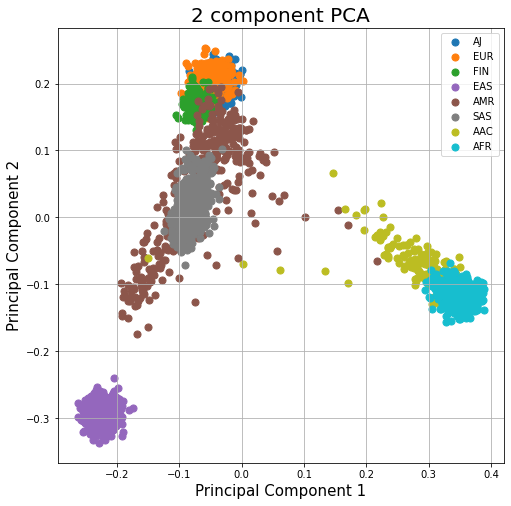

In [7]:
# read ancestry file
ancestry = pd.read_csv(f'{ref_dir_path}/ref_panel_ancestry.txt', sep='\t', header=None, names=['FID','IID','label'])
ref_fam = pd.read_csv(f'{ref_panel}.fam', sep=' ', header=None)
ref_labeled = ref_fam.merge(ancestry, how='left', left_on=[0,1], right_on=['FID','IID'])

pca = pd.read_csv(f'{ref_panel_common_snps}.pcs', sep='\t')

# combined_labels
labeled_pca = pca.merge(ref_labeled, how='left', on=['FID','IID'])
labeled_pca.drop(columns=[0,1,2,3,4,5],inplace=True)
print(labeled_pca.label.value_counts())
# plot it!
plot_pcs(labeled_pca, dim1='PC1',dim2='PC2')

In [8]:
# get reference alleles from ref_panel_common_snps
ref_panel_common_snps_ref_alleles = f'{ref_panel_common_snps}.ref_allele'
ref_panel_common_snps_bim = pd.read_csv(f'{ref_panel_common_snps}.bim', header=None, sep='\t')
ref_panel_common_snps_bim.columns = ['chr', 'rsid', 'kb', 'pos', 'a1', 'a2']
ref_panel_common_snps_bim[['rsid','a1']].to_csv(ref_panel_common_snps_ref_alleles, sep='\t', header=False, index=False)

In [9]:
geno_common_snps = f'{geno_het}_common_snps'
common_snps = f'{ref_panel_common_snps}.common_snps'
ext_snps_cmd = f'plink --bfile {geno_het} --extract {common_snps} --reference-allele {ref_panel_common_snps_ref_alleles} --make-bed --out {geno_common_snps}'
shell_do(ext_snps_cmd)

Executing: plink --bfile /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het --extract /data/vitaled2/test_data/FIN/ref_panel_common_snps.common_snps --reference-allele /data/vitaled2/test_data/FIN/ref_panel_common_snps.ref_allele --make-bed --out /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_common_snps


In [10]:
# project new samples onto ref pcs

pca_projection(geno_common_snps, f'{ref_panel_common_snps}.meansd', f'{ref_panel_common_snps}.loadings', f'{geno_common_snps}.projections')

projected = pd.read_csv(f'{geno_common_snps}.projections', sep='\t')
projected['label'] = 'new'
total_pca = labeled_pca.append(projected)
# total_pca[['FID', 'IID', 'label']].to_csv(f'{merged_ref_geno}.labels', sep='\t', index=False)

Executing: flashpca --bfile /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_common_snps --project --inmeansd /data/vitaled2/test_data/FIN/ref_panel_common_snps.meansd --inload /data/vitaled2/test_data/FIN/ref_panel_common_snps.loadings --outproj /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_common_snps.projections -v


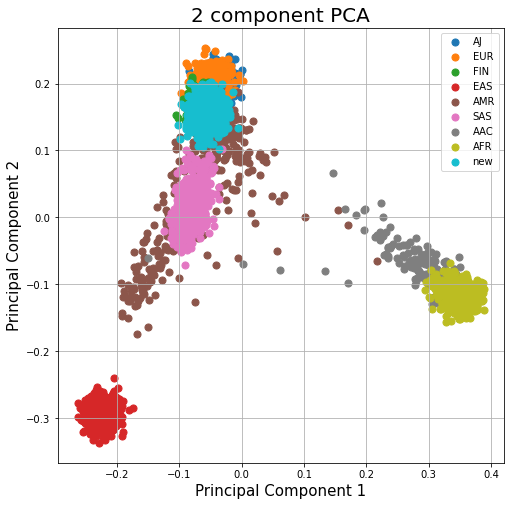

In [11]:
plot_pcs(total_pca, dim1='PC1', dim2='PC2')

In [12]:
# set new samples aside for labeling after training the model
X_new = projected.drop(columns=['FID','IID','label'])
X_new_ids = projected[['FID','IID']]
X_new

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   -0.051026  0.163349 -0.045647  0.028261 -0.106747  0.016087 -0.017881   
1   -0.057895  0.149942 -0.003634  0.032355 -0.114433  0.018478 -0.020572   
2   -0.059496  0.159299 -0.058141  0.024251 -0.110982  0.021066 -0.056012   
3   -0.064628  0.176359 -0.009121  0.008910 -0.076016  0.009421 -0.043757   
4   -0.062352  0.131672 -0.025931 -0.005106 -0.108630  0.012555 -0.041459   
..        ...       ...       ...       ...       ...       ...       ...   
874 -0.031059  0.165334 -0.038723 -0.008583 -0.113556  0.007448 -0.031459   
875 -0.065569  0.182908 -0.040237  0.022788 -0.125043 -0.008044 -0.032329   
876 -0.048164  0.142696 -0.013801  0.001120 -0.100972  0.004684 -0.015334   
877 -0.048221  0.158918 -0.044499  0.016858 -0.111555  0.008927 -0.032804   
878 -0.038346  0.159040 -0.028601  0.039285 -0.108177  0.008189 -0.038532   

          PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0    0.077347  0.016743  0.009134 -0.019035 -0.009806  0.004380 -0.015858   
1    0.045365  0.014527 -0.017955  0.002792  0.002506  0.001455 -0.000303   
2    0.071027 -0.015720  0.016951 -0.012762 -0.018503 -0.011125 -0.010941   
3    0.047273  0.011580 -0.009792  0.034159 -0.004406 -0.032355 -0.022254   
4    0.022052 -0.012729  0.020075 -0.001471 -0.000919  0.012086 -0.008149   
..        ...       ...       ...       ...       ...       ...       ...   
874  0.072858  0.001486 -0.004225 -0.008497  0.001956 -0.012912  0.025046   
875  0.068337  0.012509 -0.009795 -0.005883  0.003562 -0.031087 -0.040304   
876  0.039490  0.004154  0.000391  0.012035 -0.013651 -0.010353 -0.002253   
877  0.037482 -0.011507  0.006757 -0.022739 -0.002767  0.022563 -0.001017   
878  0.055308 -0.002058 -0.016923 -0.008690 -0.006260 -0.020033  0.018840   

         PC15      PC16      PC17      PC18      PC19      PC20  
0   -0.003751  0.002167 -0.002569 -0.009874  0.010162  0.007771  
1    0.000610 -0.004141  0.022772 -0.000215 -0.004222 -0.009468  
2   -0.002164 -0.008435  0.012406  0.034211  0.013803 -0.001814  
3   -0.018053 -0.035888 -0.003794  0.014416 -0.003362 -0.015015  
4   -0.014178 -0.028212 -0.023980 -0.015610 -0.025647 -0.003502  
..        ...       ...       ...       ...       ...       ...  
874  0.003094 -0.025762 -0.013397  0.007053  0.005867 -0.004581  
875  0.008574  0.023248 -0.007333 -0.011199  0.021008 -0.013177  
876 -0.014586  0.023895  0.008025  0.006220 -0.012983 -0.016171  
877 -0.020487  0.024988 -0.013926 -0.000052  0.011791 -0.006698  
878  0.031231 -0.006709 -0.003675  0.016446  0.015391  0.013377  

[879 rows x 20 columns]

In [12]:
# grab X and Y
X = labeled_pca.drop(columns=['label'])
y = labeled_pca.label

#encode labels
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# train/test split 1kg pca data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

IDs_train = X_train[['FID', 'IID']]
IDs_test = X_test[['FID', 'IID']]
X_train = X_train.drop(columns=['FID','IID'])
X_test = X_test.drop(columns=['FID','IID'])

In [13]:
umap = UMAP(random_state=123)
svc = LinearSVC(dual=False, random_state=123)

0.9638887617012617
{'C': 1000}
Accuracy on the test set: 0.9798319327731092


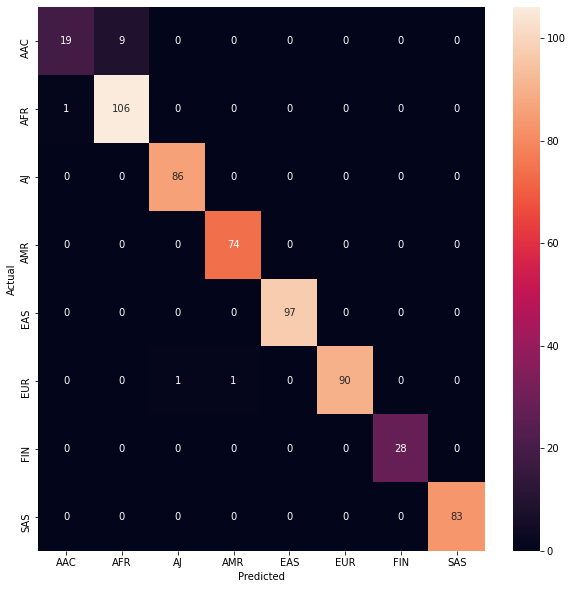

In [15]:
# adapted from UMAP as a Feature Extraction Technique for Classification (https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_feature_extraction_classification.html)

params = {"C": [10**i for i in range(-3,4)]}
cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
grid = GridSearchCV(svc, params, cv=cross_validation, scoring='balanced_accuracy')
grid.fit(X_train, y_train)

print(grid.best_score_)                          
print(grid.best_params_)

clf = grid.best_estimator_
print(f"Accuracy on the test set: {clf.score(X_test, y_test)}")
clf_pred = clf.predict(X_test)

clf_c_matrix = metrics.confusion_matrix(y_test, clf_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(clf_c_matrix, annot=True, fmt='d',
            xticklabels=le.inverse_transform([i for i in range(8)]), yticklabels=le.inverse_transform([i for i in range(8)]))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [14]:
# Transformation with UMAP followed by classification with svc

pipeline = Pipeline([("umap", umap), ("svc", svc)])
param_grid = {
    "umap__n_neighbors": [2, 5, 10],
    "umap__n_components": [3, 5, 15],
    "umap__a": [1.0, 1.25, 1.5],
    "umap__b": [0.25, 0.5, 0.75],
    "svc__C": [10**i for i in range(-3,3)],
}

cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
pipe_grid = GridSearchCV(pipeline, param_grid, cv=cross_validation, scoring='balanced_accuracy')
pipe_grid.fit(X_train, y_train)

print(pipe_grid.best_score_)
print(pipe_grid.best_params_)

pipe_clf = pipe_grid.best_estimator_
print(f"Accuracy on the test set with UMAP transformation: {pipe_clf.score(X_test, y_test)}")
pipe_clf_pred = pipe_clf.predict(X_test)

pipe_clf_c_matrix = metrics.confusion_matrix(y_test, pipe_clf_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pipe_clf_c_matrix, annot=True, fmt='d',
            xticklabels=le.inverse_transform([i for i in range(8)]), yticklabels=le.inverse_transform([i for i in range(8)]))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# dump best estimator to pkl
joblib.dump(pipe_clf, f'{out_path}/umap_linearsvc_ancestry_model.pkl')

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to rand

inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 374)	0.5854974
  (0, 376)	0.5937127
  (0, 743)	0.57051486
  (0, 987)	0.5875363
  (0, 1120)	0.57837844
  (1, 21)	0.6010477
  (1, 347)	0.5720432
  (1, 1227)	0.5712537
  (1, 1736)	0.60692364
  (1, 1866)	0.57757443
  (2, 350)	0.60649616
  (2, 370)	0.5687426
  (2, 698)	0.60731417
  (2, 1227)	0.5650695
  (2, 1353)	0.58162975
  (3, 660)	0.5908427
  (3, 845)	0.5758851
  (3, 1093)	0.5769016
  (3, 1555)	0.578295
  (3, 1825)	0.6220263
  (4, 960)	0.5701071
  (4, 1098)	0.5738594
  (4, 1182)	0.6018583
  (4, 1245)	0.5761022
  (4, 1419)	0.60292816
  :	:
  (471, 171)	0.62033576
  (471, 451)	0.6030095
  (471, 989)	0.5659014
  (471, 1261)	0.587462
  (471, 1262)	0.56554747
  (472, 396)	0.59048325
  (472, 955)	0.6019829
  (472, 1194)	0.5707411
  (472, 1631)	0.6251904
  (472, 1825)	0.558717
  (473, 106)	0.60138947
  (473, 253)	0.57179683
  (473, 899)	0.5794054
  (473, 1604)	0.5929089
  (473, 1610)	0.5778099
  (474, 49)	0.6025179
  (474, 735)	0.573981
  (474, 759)	0.60565007
  (474, 80

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 29)	0.3500982
  (0, 146)	0.36496446
  (0, 161)	0.35866532
  (0, 446)	0.40127465
  (0, 617)	0.35712928
  (0, 753)	0.38998827
  (0, 1070)	0.3493729
  (0, 1239)	0.3721067
  (0, 1399)	0.37832895
  (0, 1562)	0.4812509
  (1, 282)	0.36973196
  (1, 335)	0.38992074
  (1, 517)	0.39159507
  (1, 523)	0.35615388
  (1, 557)	0.35542697
  (1, 558)	0.36648977
  (1, 588)	0.3777792
  (1, 1427)	0.41444206
  (1, 1596)	0.35690826
  (1, 1835)	0.3579238
  (2, 340)	0.39218962
  (2, 531)	0.3542551
  (2, 538)	0.39745024
  (2, 603)	0.36248034
  (2, 913)	0.4616233
  :	:
  (473, 603)	0.4227547
  (473, 1122)	0.3468384
  (473, 1242)	0.36015642
  (473, 1284)	0.41523138
  (473, 1876)	0.52796
  (474, 226)	0.38726544
  (474, 280)	0.3438669
  (474, 483)	0.5121865
  (474, 665)	0.37407747
  (474, 976)	0.34083888
  (474, 1357)	0.39960638
  (474, 1467)	0.37398535
  (474, 1506)	0.37562725
  (474, 1507)	0.3688255
  (474, 1738)	0.35783383
  (475, 77)	0.37652984
  (475, 92)	0.38427067
  (475, 427)	0.3569425

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 374)	0.5854974
  (0, 376)	0.5937127
  (0, 743)	0.57051486
  (0, 987)	0.5875363
  (0, 1120)	0.57837844
  (1, 21)	0.6010477
  (1, 347)	0.5720432
  (1, 1227)	0.5712537
  (1, 1736)	0.60692364
  (1, 1866)	0.57757443
  (2, 350)	0.60649616
  (2, 370)	0.5687426
  (2, 698)	0.60731417
  (2, 1227)	0.5650695
  (2, 1353)	0.58162975
  (3, 660)	0.5908427
  (3, 845)	0.5758851
  (3, 1093)	0.5769016
  (3, 1555)	0.578295
  (3, 1825)	0.6220263
  (4, 960)	0.5701071
  (4, 1098)	0.5738594
  (4, 1182)	0.6018583
  (4, 1245)	0.5761022
  (4, 1419)	0.60292816
  :	:
  (471, 171)	0.62033576
  (471, 451)	0.6030095
  (471, 989)	0.5659014
  (471, 1261)	0.587462
  (471, 1262)	0.56554747
  (472, 396)	0.59048325
  (472, 955)	0.6019829
  (472, 1194)	0.5707411
  (472, 1631)	0.6251904
  (472, 1825)	0.558717
  (473, 106)	0.60138947
  (473, 253)	0.57179683
  (473, 899)	0.5794054
  (473, 1604)	0.5929089
  (473, 1610)	0.5778099
  (474, 49)	0.6025179
  (474, 735)	0.573981
  (474, 759)	0.60565007
  (474, 80

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 567)	0.5745969
  (0, 768)	0.5908446
  (0, 1070)	0.6143057
  (0, 1303)	0.5875697
  (0, 1540)	0.5689225
  (1, 50)	0.60043913
  (1, 309)	0.5998581
  (1, 447)	0.5642323
  (1, 1160)	0.5760138
  (1, 1664)	0.5818144
  (2, 68)	0.59992284
  (2, 409)	0.5879677
  (2, 529)	0.58863974
  (2, 1092)	0.5680374
  (2, 1850)	0.5772771
  (3, 292)	0.5837297
  (3, 460)	0.5682487
  (3, 1422)	0.5808662
  (3, 1806)	0.5998113
  (3, 1810)	0.58908606
  (4, 270)	0.598252
  (4, 378)	0.59213895
  (4, 458)	0.56868654
  (4, 1197)	0.5628484
  (4, 1470)	0.6102395
  :	:
  (471, 271)	0.5766207
  (471, 460)	0.57236946
  (471, 1207)	0.5914509
  (471, 1476)	0.5979381
  (471, 1758)	0.58148783
  (472, 204)	0.5966325
  (472, 283)	0.57969594
  (472, 445)	0.5800668
  (472, 565)	0.5734958
  (472, 1353)	0.5886698
  (473, 794)	0.5808002
  (473, 823)	0.5663377
  (473, 849)	0.5802216
  (473, 1497)	0.59456867
  (473, 1656)	0.6377786
  (474, 849)	0.5954813
  (474, 996)	0.5596476
  (474, 1333)	0.573629
  (474, 1656)

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 227)	0.5904486
  (0, 523)	0.55279
  (0, 619)	0.61714387
  (0, 822)	0.56154525
  (0, 1047)	0.6240854
  (1, 425)	0.57745945
  (1, 510)	0.58684075
  (1, 617)	0.5882146
  (1, 1027)	0.58344436
  (1, 1154)	0.57418436
  (2, 158)	0.6358666
  (2, 428)	0.5720485
  (2, 565)	0.59713465
  (2, 1149)	0.5612614
  (2, 1280)	0.59147614
  (3, 98)	0.58379525
  (3, 447)	0.58664095
  (3, 897)	0.5776743
  (3, 1061)	0.57381564
  (3, 1280)	0.59510297
  (4, 217)	0.6052569
  (4, 429)	0.57644564
  (4, 858)	0.5837567
  (4, 1020)	0.5911791
  (4, 1632)	0.5705393
  :	:
  (471, 17)	0.5694524
  (471, 790)	0.59030795
  (471, 1345)	0.5991498
  (471, 1420)	0.58987707
  (471, 1527)	0.5722861
  (472, 163)	0.5663695
  (472, 278)	0.5853105
  (472, 478)	0.60150737
  (472, 676)	0.5687495
  (472, 1887)	0.6023209
  (473, 116)	0.6273123
  (473, 642)	0.5756901
  (473, 1534)	0.57043314
  (473, 1578)	0.5748274
  (473, 1695)	0.6009709
  (474, 217)	0.5705601
  (474, 537)	0.57528824
  (474, 1060)	0.5873779
  (474,

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 232)	0.34918085
  (0, 374)	0.404449
  (0, 376)	0.41409227
  (0, 743)	0.38710204
  (0, 800)	0.34635648
  (0, 987)	0.40683362
  (0, 1103)	0.35895643
  (0, 1120)	0.39616787
  (0, 1473)	0.3397737
  (0, 1688)	0.33310223
  (1, 21)	0.40810835
  (1, 109)	0.35454232
  (1, 197)	0.35328898
  (1, 347)	0.3740765
  (1, 469)	0.35963523
  (1, 557)	0.36291158
  (1, 1227)	0.3731681
  (1, 1736)	0.4151583
  (1, 1761)	0.35572502
  (1, 1866)	0.38046756
  (2, 97)	0.34662637
  (2, 116)	0.35151944
  (2, 350)	0.4181475
  (2, 370)	0.37381813
  (2, 698)	0.41913134
  :	:
  (473, 1472)	0.35976866
  (473, 1604)	0.39511287
  (473, 1610)	0.37741518
  (473, 1682)	0.3656934
  (473, 1818)	0.36970755
  (474, 11)	0.36053988
  (474, 49)	0.40330687
  (474, 323)	0.36324692
  (474, 324)	0.3647849
  (474, 492)	0.36255324
  (474, 571)	0.3612514
  (474, 735)	0.36971498
  (474, 759)	0.4070723
  (474, 807)	0.36484888
  (474, 931)	0.37167817
  (475, 93)	0.40011317
  (475, 204)	0.36715835
  (475, 212)	0.3650312

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 65)	0.40921682
  (0, 88)	0.40721038
  (0, 105)	0.3684156
  (0, 597)	0.3462606
  (0, 900)	0.3557731
  (0, 1120)	0.3475522
  (0, 1253)	0.362209
  (0, 1288)	0.38414535
  (0, 1335)	0.35877523
  (0, 1755)	0.3915888
  (1, 127)	0.4006214
  (1, 164)	0.38784984
  (1, 707)	0.35661972
  (1, 809)	0.38232264
  (1, 943)	0.3811498
  (1, 1003)	0.4095109
  (1, 1084)	0.3579925
  (1, 1331)	0.36022022
  (1, 1570)	0.3450639
  (1, 1612)	0.35008544
  (2, 42)	0.35793856
  (2, 511)	0.43350387
  (2, 589)	0.38100514
  (2, 983)	0.38098654
  (2, 999)	0.37201285
  :	:
  (473, 1057)	0.36768153
  (473, 1352)	0.3269383
  (473, 1395)	0.46886355
  (473, 1734)	0.3653514
  (473, 1902)	0.3701548
  (474, 127)	0.34847772
  (474, 263)	0.3876125
  (474, 501)	0.36144397
  (474, 988)	0.46534258
  (474, 1003)	0.3659443
  (474, 1084)	0.3864688
  (474, 1221)	0.37289175
  (474, 1331)	0.37845027
  (474, 1495)	0.37025824
  (474, 1612)	0.35038087
  (475, 363)	0.3473916
  (475, 576)	0.37363318
  (475, 671)	0.32892

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 446)	0.59403944
  (0, 753)	0.58445126
  (0, 1239)	0.5690125
  (0, 1399)	0.57442015
  (0, 1562)	0.6589226
  (1, 282)	0.5696873
  (1, 335)	0.58707523
  (1, 517)	0.58849955
  (1, 588)	0.5766664
  (1, 1427)	0.6076768
  (2, 340)	0.5829508
  (2, 538)	0.5874463
  (2, 603)	0.55706686
  (2, 913)	0.6403929
  (2, 1421)	0.5944641
  (3, 64)	0.58101666
  (3, 326)	0.5818952
  (3, 512)	0.5764075
  (3, 1618)	0.58261204
  (3, 1757)	0.619207
  (4, 326)	0.6338672
  (4, 1131)	0.5770173
  (4, 1203)	0.5895083
  (4, 1615)	0.5749466
  (4, 1630)	0.5804507
  :	:
  (471, 346)	0.5927469
  (471, 383)	0.5704406
  (471, 1685)	0.618907
  (471, 1693)	0.5800962
  (471, 1824)	0.57864434
  (472, 971)	0.5754313
  (472, 1106)	0.5737633
  (472, 1146)	0.62125385
  (472, 1187)	0.60089356
  (472, 1715)	0.57184094
  (473, 97)	0.57097894
  (473, 603)	0.60379606
  (473, 1242)	0.5496759
  (473, 1284)	0.59747607
  (473, 1876)	0.6877744
  (474, 226)	0.58320713
  (474, 483)	0.6836566
  (474, 665)	0.57183397
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 65)	0.5987318
  (0, 88)	0.5970447
  (0, 105)	0.56369686
  (0, 1288)	0.5773902
  (0, 1755)	0.58378667
  (1, 127)	0.59129405
  (1, 164)	0.58039165
  (1, 809)	0.5756261
  (1, 943)	0.57461107
  (1, 1003)	0.5987954
  (2, 511)	0.61546004
  (2, 589)	0.5710107
  (2, 983)	0.5709945
  (2, 1319)	0.61344105
  (2, 1544)	0.5664824
  (3, 377)	0.57319844
  (3, 387)	0.64050335
  (3, 550)	0.5722948
  (3, 854)	0.59788895
  (3, 1663)	0.5785364
  (4, 2)	0.58386266
  (4, 370)	0.63503623
  (4, 724)	0.5837314
  (4, 731)	0.57764745
  (4, 983)	0.5766845
  :	:
  (471, 115)	0.57547593
  (471, 346)	0.63036036
  (471, 731)	0.6050928
  (471, 1870)	0.5722962
  (471, 1884)	0.5690641
  (472, 370)	0.60190505
  (472, 983)	0.56801313
  (472, 1093)	0.60231584
  (472, 1099)	0.58444476
  (472, 1460)	0.56755924
  (473, 80)	0.5666117
  (473, 292)	0.61081636
  (473, 529)	0.5813179
  (473, 1395)	0.6455928
  (473, 1902)	0.56318194
  (474, 263)	0.5858545
  (474, 988)	0.6494865
  (474, 1084)	0.58487856
  (474

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to rand

inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 446)	0.59403944
  (0, 753)	0.58445126
  (0, 1239)	0.5690125
  (0, 1399)	0.57442015
  (0, 1562)	0.6589226
  (1, 282)	0.5696873
  (1, 335)	0.58707523
  (1, 517)	0.58849955
  (1, 588)	0.5766664
  (1, 1427)	0.6076768
  (2, 340)	0.5829508
  (2, 538)	0.5874463
  (2, 603)	0.55706686
  (2, 913)	0.6403929
  (2, 1421)	0.5944641
  (3, 64)	0.58101666
  (3, 326)	0.5818952
  (3, 512)	0.5764075
  (3, 1618)	0.58261204
  (3, 1757)	0.619207
  (4, 326)	0.6338672
  (4, 1131)	0.5770173
  (4, 1203)	0.5895083
  (4, 1615)	0.5749466
  (4, 1630)	0.5804507
  :	:
  (471, 346)	0.5927469
  (471, 383)	0.5704406
  (471, 1685)	0.618907
  (471, 1693)	0.5800962
  (471, 1824)	0.57864434
  (472, 971)	0.5754313
  (472, 1106)	0.5737633
  (472, 1146)	0.62125385
  (472, 1187)	0.60089356
  (472, 1715)	0.57184094
  (473, 97)	0.57097894
  (473, 603)	0.60379606
  (473, 1242)	0.5496759
  (473, 1284)	0.59747607
  (473, 1876)	0.6877744
  (474, 226)	0.58320713
  (474, 483)	0.6836566
  (474, 665)	0.57183397
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 227)	0.5904486
  (0, 523)	0.55279
  (0, 619)	0.61714387
  (0, 822)	0.56154525
  (0, 1047)	0.6240854
  (1, 425)	0.57745945
  (1, 510)	0.58684075
  (1, 617)	0.5882146
  (1, 1027)	0.58344436
  (1, 1154)	0.57418436
  (2, 158)	0.6358666
  (2, 428)	0.5720485
  (2, 565)	0.59713465
  (2, 1149)	0.5612614
  (2, 1280)	0.59147614
  (3, 98)	0.58379525
  (3, 447)	0.58664095
  (3, 897)	0.5776743
  (3, 1061)	0.57381564
  (3, 1280)	0.59510297
  (4, 217)	0.6052569
  (4, 429)	0.57644564
  (4, 858)	0.5837567
  (4, 1020)	0.5911791
  (4, 1632)	0.5705393
  :	:
  (471, 17)	0.5694524
  (471, 790)	0.59030795
  (471, 1345)	0.5991498
  (471, 1420)	0.58987707
  (471, 1527)	0.5722861
  (472, 163)	0.5663695
  (472, 278)	0.5853105
  (472, 478)	0.60150737
  (472, 676)	0.5687495
  (472, 1887)	0.6023209
  (473, 116)	0.6273123
  (473, 642)	0.5756901
  (473, 1534)	0.57043314
  (473, 1578)	0.5748274
  (473, 1695)	0.6009709
  (474, 217)	0.5705601
  (474, 537)	0.57528824
  (474, 1060)	0.5873779
  (474,

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 29)	0.3500982
  (0, 146)	0.36496446
  (0, 161)	0.35866532
  (0, 446)	0.40127465
  (0, 617)	0.35712928
  (0, 753)	0.38998827
  (0, 1070)	0.3493729
  (0, 1239)	0.3721067
  (0, 1399)	0.37832895
  (0, 1562)	0.4812509
  (1, 282)	0.36973196
  (1, 335)	0.38992074
  (1, 517)	0.39159507
  (1, 523)	0.35615388
  (1, 557)	0.35542697
  (1, 558)	0.36648977
  (1, 588)	0.3777792
  (1, 1427)	0.41444206
  (1, 1596)	0.35690826
  (1, 1835)	0.3579238
  (2, 340)	0.39218962
  (2, 531)	0.3542551
  (2, 538)	0.39745024
  (2, 603)	0.36248034
  (2, 913)	0.4616233
  :	:
  (473, 603)	0.4227547
  (473, 1122)	0.3468384
  (473, 1242)	0.36015642
  (473, 1284)	0.41523138
  (473, 1876)	0.52796
  (474, 226)	0.38726544
  (474, 280)	0.3438669
  (474, 483)	0.5121865
  (474, 665)	0.37407747
  (474, 976)	0.34083888
  (474, 1357)	0.39960638
  (474, 1467)	0.37398535
  (474, 1506)	0.37562725
  (474, 1507)	0.3688255
  (474, 1738)	0.35783383
  (475, 77)	0.37652984
  (475, 92)	0.38427067
  (475, 427)	0.3569425

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 70)	0.35914952
  (0, 556)	0.36508977
  (0, 567)	0.37201282
  (0, 600)	0.3622291
  (0, 768)	0.39099348
  (0, 989)	0.35881397
  (0, 1070)	0.4191307
  (0, 1303)	0.38713434
  (0, 1470)	0.36102518
  (0, 1540)	0.3654821
  (1, 49)	0.3501131
  (1, 50)	0.4093827
  (1, 309)	0.40868932
  (1, 447)	0.36714426
  (1, 723)	0.3539401
  (1, 1117)	0.3537433
  (1, 1160)	0.38067177
  (1, 1548)	0.35943493
  (1, 1664)	0.387409
  (1, 1809)	0.3607838
  (2, 68)	0.40624955
  (2, 364)	0.35509303
  (2, 409)	0.39208603
  (2, 473)	0.35845342
  (2, 529)	0.39287642
  :	:
  (473, 849)	0.38352612
  (473, 1497)	0.40037882
  (473, 1615)	0.35845342
  (473, 1656)	0.45301378
  (473, 1683)	0.35472286
  (474, 695)	0.3521194
  (474, 755)	0.35760647
  (474, 849)	0.4103519
  (474, 857)	0.33323747
  (474, 918)	0.3511044
  (474, 996)	0.3688437
  (474, 1333)	0.3848189
  (474, 1351)	0.35621262
  (474, 1656)	0.40763068
  (474, 1683)	0.4894891
  (475, 175)	0.36792013
  (475, 316)	0.3419358
  (475, 342)	0.3562093


/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 227)	0.5904486
  (0, 523)	0.55279
  (0, 619)	0.61714387
  (0, 822)	0.56154525
  (0, 1047)	0.6240854
  (1, 425)	0.57745945
  (1, 510)	0.58684075
  (1, 617)	0.5882146
  (1, 1027)	0.58344436
  (1, 1154)	0.57418436
  (2, 158)	0.6358666
  (2, 428)	0.5720485
  (2, 565)	0.59713465
  (2, 1149)	0.5612614
  (2, 1280)	0.59147614
  (3, 98)	0.58379525
  (3, 447)	0.58664095
  (3, 897)	0.5776743
  (3, 1061)	0.57381564
  (3, 1280)	0.59510297
  (4, 217)	0.6052569
  (4, 429)	0.57644564
  (4, 858)	0.5837567
  (4, 1020)	0.5911791
  (4, 1632)	0.5705393
  :	:
  (471, 17)	0.5694524
  (471, 790)	0.59030795
  (471, 1345)	0.5991498
  (471, 1420)	0.58987707
  (471, 1527)	0.5722861
  (472, 163)	0.5663695
  (472, 278)	0.5853105
  (472, 478)	0.60150737
  (472, 676)	0.5687495
  (472, 1887)	0.6023209
  (473, 116)	0.6273123
  (473, 642)	0.5756901
  (473, 1534)	0.57043314
  (473, 1578)	0.5748274
  (473, 1695)	0.6009709
  (474, 217)	0.5705601
  (474, 537)	0.57528824
  (474, 1060)	0.5873779
  (474,

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 70)	0.35914952
  (0, 556)	0.36508977
  (0, 567)	0.37201282
  (0, 600)	0.3622291
  (0, 768)	0.39099348
  (0, 989)	0.35881397
  (0, 1070)	0.4191307
  (0, 1303)	0.38713434
  (0, 1470)	0.36102518
  (0, 1540)	0.3654821
  (1, 49)	0.3501131
  (1, 50)	0.4093827
  (1, 309)	0.40868932
  (1, 447)	0.36714426
  (1, 723)	0.3539401
  (1, 1117)	0.3537433
  (1, 1160)	0.38067177
  (1, 1548)	0.35943493
  (1, 1664)	0.387409
  (1, 1809)	0.3607838
  (2, 68)	0.40624955
  (2, 364)	0.35509303
  (2, 409)	0.39208603
  (2, 473)	0.35845342
  (2, 529)	0.39287642
  :	:
  (473, 849)	0.38352612
  (473, 1497)	0.40037882
  (473, 1615)	0.35845342
  (473, 1656)	0.45301378
  (473, 1683)	0.35472286
  (474, 695)	0.3521194
  (474, 755)	0.35760647
  (474, 849)	0.4103519
  (474, 857)	0.33323747
  (474, 918)	0.3511044
  (474, 996)	0.3688437
  (474, 1333)	0.3848189
  (474, 1351)	0.35621262
  (474, 1656)	0.40763068
  (474, 1683)	0.4894891
  (475, 175)	0.36792013
  (475, 316)	0.3419358
  (475, 342)	0.3562093


/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 446)	0.59403944
  (0, 753)	0.58445126
  (0, 1239)	0.5690125
  (0, 1399)	0.57442015
  (0, 1562)	0.6589226
  (1, 282)	0.5696873
  (1, 335)	0.58707523
  (1, 517)	0.58849955
  (1, 588)	0.5766664
  (1, 1427)	0.6076768
  (2, 340)	0.5829508
  (2, 538)	0.5874463
  (2, 603)	0.55706686
  (2, 913)	0.6403929
  (2, 1421)	0.5944641
  (3, 64)	0.58101666
  (3, 326)	0.5818952
  (3, 512)	0.5764075
  (3, 1618)	0.58261204
  (3, 1757)	0.619207
  (4, 326)	0.6338672
  (4, 1131)	0.5770173
  (4, 1203)	0.5895083
  (4, 1615)	0.5749466
  (4, 1630)	0.5804507
  :	:
  (471, 346)	0.5927469
  (471, 383)	0.5704406
  (471, 1685)	0.618907
  (471, 1693)	0.5800962
  (471, 1824)	0.57864434
  (472, 971)	0.5754313
  (472, 1106)	0.5737633
  (472, 1146)	0.62125385
  (472, 1187)	0.60089356
  (472, 1715)	0.57184094
  (473, 97)	0.57097894
  (473, 603)	0.60379606
  (473, 1242)	0.5496759
  (473, 1284)	0.59747607
  (473, 1876)	0.6877744
  (474, 226)	0.58320713
  (474, 483)	0.6836566
  (474, 665)	0.57183397
  (4

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 374)	0.5854974
  (0, 376)	0.5937127
  (0, 743)	0.57051486
  (0, 987)	0.5875363
  (0, 1120)	0.57837844
  (1, 21)	0.6010477
  (1, 347)	0.5720432
  (1, 1227)	0.5712537
  (1, 1736)	0.60692364
  (1, 1866)	0.57757443
  (2, 350)	0.60649616
  (2, 370)	0.5687426
  (2, 698)	0.60731417
  (2, 1227)	0.5650695
  (2, 1353)	0.58162975
  (3, 660)	0.5908427
  (3, 845)	0.5758851
  (3, 1093)	0.5769016
  (3, 1555)	0.578295
  (3, 1825)	0.6220263
  (4, 960)	0.5701071
  (4, 1098)	0.5738594
  (4, 1182)	0.6018583
  (4, 1245)	0.5761022
  (4, 1419)	0.60292816
  :	:
  (471, 171)	0.62033576
  (471, 451)	0.6030095
  (471, 989)	0.5659014
  (471, 1261)	0.587462
  (471, 1262)	0.56554747
  (472, 396)	0.59048325
  (472, 955)	0.6019829
  (472, 1194)	0.5707411
  (472, 1631)	0.6251904
  (472, 1825)	0.558717
  (473, 106)	0.60138947
  (473, 253)	0.57179683
  (473, 899)	0.5794054
  (473, 1604)	0.5929089
  (473, 1610)	0.5778099
  (474, 49)	0.6025179
  (474, 735)	0.573981
  (474, 759)	0.60565007
  (474, 80

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 446)	0.59403944
  (0, 753)	0.58445126
  (0, 1239)	0.5690125
  (0, 1399)	0.57442015
  (0, 1562)	0.6589226
  (1, 282)	0.5696873
  (1, 335)	0.58707523
  (1, 517)	0.58849955
  (1, 588)	0.5766664
  (1, 1427)	0.6076768
  (2, 340)	0.5829508
  (2, 538)	0.5874463
  (2, 603)	0.55706686
  (2, 913)	0.6403929
  (2, 1421)	0.5944641
  (3, 64)	0.58101666
  (3, 326)	0.5818952
  (3, 512)	0.5764075
  (3, 1618)	0.58261204
  (3, 1757)	0.619207
  (4, 326)	0.6338672
  (4, 1131)	0.5770173
  (4, 1203)	0.5895083
  (4, 1615)	0.5749466
  (4, 1630)	0.5804507
  :	:
  (471, 346)	0.5927469
  (471, 383)	0.5704406
  (471, 1685)	0.618907
  (471, 1693)	0.5800962
  (471, 1824)	0.57864434
  (472, 971)	0.5754313
  (472, 1106)	0.5737633
  (472, 1146)	0.62125385
  (472, 1187)	0.60089356
  (472, 1715)	0.57184094
  (473, 97)	0.57097894
  (473, 603)	0.60379606
  (473, 1242)	0.5496759
  (473, 1284)	0.59747607
  (473, 1876)	0.6877744
  (474, 226)	0.58320713
  (474, 483)	0.6836566
  (474, 665)	0.57183397
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 567)	0.5745969
  (0, 768)	0.5908446
  (0, 1070)	0.6143057
  (0, 1303)	0.5875697
  (0, 1540)	0.5689225
  (1, 50)	0.60043913
  (1, 309)	0.5998581
  (1, 447)	0.5642323
  (1, 1160)	0.5760138
  (1, 1664)	0.5818144
  (2, 68)	0.59992284
  (2, 409)	0.5879677
  (2, 529)	0.58863974
  (2, 1092)	0.5680374
  (2, 1850)	0.5772771
  (3, 292)	0.5837297
  (3, 460)	0.5682487
  (3, 1422)	0.5808662
  (3, 1806)	0.5998113
  (3, 1810)	0.58908606
  (4, 270)	0.598252
  (4, 378)	0.59213895
  (4, 458)	0.56868654
  (4, 1197)	0.5628484
  (4, 1470)	0.6102395
  :	:
  (471, 271)	0.5766207
  (471, 460)	0.57236946
  (471, 1207)	0.5914509
  (471, 1476)	0.5979381
  (471, 1758)	0.58148783
  (472, 204)	0.5966325
  (472, 283)	0.57969594
  (472, 445)	0.5800668
  (472, 565)	0.5734958
  (472, 1353)	0.5886698
  (473, 794)	0.5808002
  (473, 823)	0.5663377
  (473, 849)	0.5802216
  (473, 1497)	0.59456867
  (473, 1656)	0.6377786
  (474, 849)	0.5954813
  (474, 996)	0.5596476
  (474, 1333)	0.573629
  (474, 1656)

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 227)	0.5904486
  (0, 523)	0.55279
  (0, 619)	0.61714387
  (0, 822)	0.56154525
  (0, 1047)	0.6240854
  (1, 425)	0.57745945
  (1, 510)	0.58684075
  (1, 617)	0.5882146
  (1, 1027)	0.58344436
  (1, 1154)	0.57418436
  (2, 158)	0.6358666
  (2, 428)	0.5720485
  (2, 565)	0.59713465
  (2, 1149)	0.5612614
  (2, 1280)	0.59147614
  (3, 98)	0.58379525
  (3, 447)	0.58664095
  (3, 897)	0.5776743
  (3, 1061)	0.57381564
  (3, 1280)	0.59510297
  (4, 217)	0.6052569
  (4, 429)	0.57644564
  (4, 858)	0.5837567
  (4, 1020)	0.5911791
  (4, 1632)	0.5705393
  :	:
  (471, 17)	0.5694524
  (471, 790)	0.59030795
  (471, 1345)	0.5991498
  (471, 1420)	0.58987707
  (471, 1527)	0.5722861
  (472, 163)	0.5663695
  (472, 278)	0.5853105
  (472, 478)	0.60150737
  (472, 676)	0.5687495
  (472, 1887)	0.6023209
  (473, 116)	0.6273123
  (473, 642)	0.5756901
  (473, 1534)	0.57043314
  (473, 1578)	0.5748274
  (473, 1695)	0.6009709
  (474, 217)	0.5705601
  (474, 537)	0.57528824
  (474, 1060)	0.5873779
  (474,

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 232)	0.34918085
  (0, 374)	0.404449
  (0, 376)	0.41409227
  (0, 743)	0.38710204
  (0, 800)	0.34635648
  (0, 987)	0.40683362
  (0, 1103)	0.35895643
  (0, 1120)	0.39616787
  (0, 1473)	0.3397737
  (0, 1688)	0.33310223
  (1, 21)	0.40810835
  (1, 109)	0.35454232
  (1, 197)	0.35328898
  (1, 347)	0.3740765
  (1, 469)	0.35963523
  (1, 557)	0.36291158
  (1, 1227)	0.3731681
  (1, 1736)	0.4151583
  (1, 1761)	0.35572502
  (1, 1866)	0.38046756
  (2, 97)	0.34662637
  (2, 116)	0.35151944
  (2, 350)	0.4181475
  (2, 370)	0.37381813
  (2, 698)	0.41913134
  :	:
  (473, 1472)	0.35976866
  (473, 1604)	0.39511287
  (473, 1610)	0.37741518
  (473, 1682)	0.3656934
  (473, 1818)	0.36970755
  (474, 11)	0.36053988
  (474, 49)	0.40330687
  (474, 323)	0.36324692
  (474, 324)	0.3647849
  (474, 492)	0.36255324
  (474, 571)	0.3612514
  (474, 735)	0.36971498
  (474, 759)	0.4070723
  (474, 807)	0.36484888
  (474, 931)	0.37167817
  (475, 93)	0.40011317
  (475, 204)	0.36715835
  (475, 212)	0.3650312

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 29)	0.3500982
  (0, 146)	0.36496446
  (0, 161)	0.35866532
  (0, 446)	0.40127465
  (0, 617)	0.35712928
  (0, 753)	0.38998827
  (0, 1070)	0.3493729
  (0, 1239)	0.3721067
  (0, 1399)	0.37832895
  (0, 1562)	0.4812509
  (1, 282)	0.36973196
  (1, 335)	0.38992074
  (1, 517)	0.39159507
  (1, 523)	0.35615388
  (1, 557)	0.35542697
  (1, 558)	0.36648977
  (1, 588)	0.3777792
  (1, 1427)	0.41444206
  (1, 1596)	0.35690826
  (1, 1835)	0.3579238
  (2, 340)	0.39218962
  (2, 531)	0.3542551
  (2, 538)	0.39745024
  (2, 603)	0.36248034
  (2, 913)	0.4616233
  :	:
  (473, 603)	0.4227547
  (473, 1122)	0.3468384
  (473, 1242)	0.36015642
  (473, 1284)	0.41523138
  (473, 1876)	0.52796
  (474, 226)	0.38726544
  (474, 280)	0.3438669
  (474, 483)	0.5121865
  (474, 665)	0.37407747
  (474, 976)	0.34083888
  (474, 1357)	0.39960638
  (474, 1467)	0.37398535
  (474, 1506)	0.37562725
  (474, 1507)	0.3688255
  (474, 1738)	0.35783383
  (475, 77)	0.37652984
  (475, 92)	0.38427067
  (475, 427)	0.3569425

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 70)	0.35914952
  (0, 556)	0.36508977
  (0, 567)	0.37201282
  (0, 600)	0.3622291
  (0, 768)	0.39099348
  (0, 989)	0.35881397
  (0, 1070)	0.4191307
  (0, 1303)	0.38713434
  (0, 1470)	0.36102518
  (0, 1540)	0.3654821
  (1, 49)	0.3501131
  (1, 50)	0.4093827
  (1, 309)	0.40868932
  (1, 447)	0.36714426
  (1, 723)	0.3539401
  (1, 1117)	0.3537433
  (1, 1160)	0.38067177
  (1, 1548)	0.35943493
  (1, 1664)	0.387409
  (1, 1809)	0.3607838
  (2, 68)	0.40624955
  (2, 364)	0.35509303
  (2, 409)	0.39208603
  (2, 473)	0.35845342
  (2, 529)	0.39287642
  :	:
  (473, 849)	0.38352612
  (473, 1497)	0.40037882
  (473, 1615)	0.35845342
  (473, 1656)	0.45301378
  (473, 1683)	0.35472286
  (474, 695)	0.3521194
  (474, 755)	0.35760647
  (474, 849)	0.4103519
  (474, 857)	0.33323747
  (474, 918)	0.3511044
  (474, 996)	0.3688437
  (474, 1333)	0.3848189
  (474, 1351)	0.35621262
  (474, 1656)	0.40763068
  (474, 1683)	0.4894891
  (475, 175)	0.36792013
  (475, 316)	0.3419358
  (475, 342)	0.3562093


/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 446)	0.59403944
  (0, 753)	0.58445126
  (0, 1239)	0.5690125
  (0, 1399)	0.57442015
  (0, 1562)	0.6589226
  (1, 282)	0.5696873
  (1, 335)	0.58707523
  (1, 517)	0.58849955
  (1, 588)	0.5766664
  (1, 1427)	0.6076768
  (2, 340)	0.5829508
  (2, 538)	0.5874463
  (2, 603)	0.55706686
  (2, 913)	0.6403929
  (2, 1421)	0.5944641
  (3, 64)	0.58101666
  (3, 326)	0.5818952
  (3, 512)	0.5764075
  (3, 1618)	0.58261204
  (3, 1757)	0.619207
  (4, 326)	0.6338672
  (4, 1131)	0.5770173
  (4, 1203)	0.5895083
  (4, 1615)	0.5749466
  (4, 1630)	0.5804507
  :	:
  (471, 346)	0.5927469
  (471, 383)	0.5704406
  (471, 1685)	0.618907
  (471, 1693)	0.5800962
  (471, 1824)	0.57864434
  (472, 971)	0.5754313
  (472, 1106)	0.5737633
  (472, 1146)	0.62125385
  (472, 1187)	0.60089356
  (472, 1715)	0.57184094
  (473, 97)	0.57097894
  (473, 603)	0.60379606
  (473, 1242)	0.5496759
  (473, 1284)	0.59747607
  (473, 1876)	0.6877744
  (474, 226)	0.58320713
  (474, 483)	0.6836566
  (474, 665)	0.57183397
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 65)	0.5987318
  (0, 88)	0.5970447
  (0, 105)	0.56369686
  (0, 1288)	0.5773902
  (0, 1755)	0.58378667
  (1, 127)	0.59129405
  (1, 164)	0.58039165
  (1, 809)	0.5756261
  (1, 943)	0.57461107
  (1, 1003)	0.5987954
  (2, 511)	0.61546004
  (2, 589)	0.5710107
  (2, 983)	0.5709945
  (2, 1319)	0.61344105
  (2, 1544)	0.5664824
  (3, 377)	0.57319844
  (3, 387)	0.64050335
  (3, 550)	0.5722948
  (3, 854)	0.59788895
  (3, 1663)	0.5785364
  (4, 2)	0.58386266
  (4, 370)	0.63503623
  (4, 724)	0.5837314
  (4, 731)	0.57764745
  (4, 983)	0.5766845
  :	:
  (471, 115)	0.57547593
  (471, 346)	0.63036036
  (471, 731)	0.6050928
  (471, 1870)	0.5722962
  (471, 1884)	0.5690641
  (472, 370)	0.60190505
  (472, 983)	0.56801313
  (472, 1093)	0.60231584
  (472, 1099)	0.58444476
  (472, 1460)	0.56755924
  (473, 80)	0.5666117
  (473, 292)	0.61081636
  (473, 529)	0.5813179
  (473, 1395)	0.6455928
  (473, 1902)	0.56318194
  (474, 263)	0.5858545
  (474, 988)	0.6494865
  (474, 1084)	0.58487856
  (474

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 446)	0.59403944
  (0, 753)	0.58445126
  (0, 1239)	0.5690125
  (0, 1399)	0.57442015
  (0, 1562)	0.6589226
  (1, 282)	0.5696873
  (1, 335)	0.58707523
  (1, 517)	0.58849955
  (1, 588)	0.5766664
  (1, 1427)	0.6076768
  (2, 340)	0.5829508
  (2, 538)	0.5874463
  (2, 603)	0.55706686
  (2, 913)	0.6403929
  (2, 1421)	0.5944641
  (3, 64)	0.58101666
  (3, 326)	0.5818952
  (3, 512)	0.5764075
  (3, 1618)	0.58261204
  (3, 1757)	0.619207
  (4, 326)	0.6338672
  (4, 1131)	0.5770173
  (4, 1203)	0.5895083
  (4, 1615)	0.5749466
  (4, 1630)	0.5804507
  :	:
  (471, 346)	0.5927469
  (471, 383)	0.5704406
  (471, 1685)	0.618907
  (471, 1693)	0.5800962
  (471, 1824)	0.57864434
  (472, 971)	0.5754313
  (472, 1106)	0.5737633
  (472, 1146)	0.62125385
  (472, 1187)	0.60089356
  (472, 1715)	0.57184094
  (473, 97)	0.57097894
  (473, 603)	0.60379606
  (473, 1242)	0.5496759
  (473, 1284)	0.59747607
  (473, 1876)	0.6877744
  (474, 226)	0.58320713
  (474, 483)	0.6836566
  (474, 665)	0.57183397
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 227)	0.5904486
  (0, 523)	0.55279
  (0, 619)	0.61714387
  (0, 822)	0.56154525
  (0, 1047)	0.6240854
  (1, 425)	0.57745945
  (1, 510)	0.58684075
  (1, 617)	0.5882146
  (1, 1027)	0.58344436
  (1, 1154)	0.57418436
  (2, 158)	0.6358666
  (2, 428)	0.5720485
  (2, 565)	0.59713465
  (2, 1149)	0.5612614
  (2, 1280)	0.59147614
  (3, 98)	0.58379525
  (3, 447)	0.58664095
  (3, 897)	0.5776743
  (3, 1061)	0.57381564
  (3, 1280)	0.59510297
  (4, 217)	0.6052569
  (4, 429)	0.57644564
  (4, 858)	0.5837567
  (4, 1020)	0.5911791
  (4, 1632)	0.5705393
  :	:
  (471, 17)	0.5694524
  (471, 790)	0.59030795
  (471, 1345)	0.5991498
  (471, 1420)	0.58987707
  (471, 1527)	0.5722861
  (472, 163)	0.5663695
  (472, 278)	0.5853105
  (472, 478)	0.60150737
  (472, 676)	0.5687495
  (472, 1887)	0.6023209
  (473, 116)	0.6273123
  (473, 642)	0.5756901
  (473, 1534)	0.57043314
  (473, 1578)	0.5748274
  (473, 1695)	0.6009709
  (474, 217)	0.5705601
  (474, 537)	0.57528824
  (474, 1060)	0.5873779
  (474,

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 29)	0.3500982
  (0, 146)	0.36496446
  (0, 161)	0.35866532
  (0, 446)	0.40127465
  (0, 617)	0.35712928
  (0, 753)	0.38998827
  (0, 1070)	0.3493729
  (0, 1239)	0.3721067
  (0, 1399)	0.37832895
  (0, 1562)	0.4812509
  (1, 282)	0.36973196
  (1, 335)	0.38992074
  (1, 517)	0.39159507
  (1, 523)	0.35615388
  (1, 557)	0.35542697
  (1, 558)	0.36648977
  (1, 588)	0.3777792
  (1, 1427)	0.41444206
  (1, 1596)	0.35690826
  (1, 1835)	0.3579238
  (2, 340)	0.39218962
  (2, 531)	0.3542551
  (2, 538)	0.39745024
  (2, 603)	0.36248034
  (2, 913)	0.4616233
  :	:
  (473, 603)	0.4227547
  (473, 1122)	0.3468384
  (473, 1242)	0.36015642
  (473, 1284)	0.41523138
  (473, 1876)	0.52796
  (474, 226)	0.38726544
  (474, 280)	0.3438669
  (474, 483)	0.5121865
  (474, 665)	0.37407747
  (474, 976)	0.34083888
  (474, 1357)	0.39960638
  (474, 1467)	0.37398535
  (474, 1506)	0.37562725
  (474, 1507)	0.3688255
  (474, 1738)	0.35783383
  (475, 77)	0.37652984
  (475, 92)	0.38427067
  (475, 427)	0.3569425

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 70)	0.35914952
  (0, 556)	0.36508977
  (0, 567)	0.37201282
  (0, 600)	0.3622291
  (0, 768)	0.39099348
  (0, 989)	0.35881397
  (0, 1070)	0.4191307
  (0, 1303)	0.38713434
  (0, 1470)	0.36102518
  (0, 1540)	0.3654821
  (1, 49)	0.3501131
  (1, 50)	0.4093827
  (1, 309)	0.40868932
  (1, 447)	0.36714426
  (1, 723)	0.3539401
  (1, 1117)	0.3537433
  (1, 1160)	0.38067177
  (1, 1548)	0.35943493
  (1, 1664)	0.387409
  (1, 1809)	0.3607838
  (2, 68)	0.40624955
  (2, 364)	0.35509303
  (2, 409)	0.39208603
  (2, 473)	0.35845342
  (2, 529)	0.39287642
  :	:
  (473, 849)	0.38352612
  (473, 1497)	0.40037882
  (473, 1615)	0.35845342
  (473, 1656)	0.45301378
  (473, 1683)	0.35472286
  (474, 695)	0.3521194
  (474, 755)	0.35760647
  (474, 849)	0.4103519
  (474, 857)	0.33323747
  (474, 918)	0.3511044
  (474, 996)	0.3688437
  (474, 1333)	0.3848189
  (474, 1351)	0.35621262
  (474, 1656)	0.40763068
  (474, 1683)	0.4894891
  (475, 175)	0.36792013
  (475, 316)	0.3419358
  (475, 342)	0.3562093


/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 232)	0.34918085
  (0, 374)	0.404449
  (0, 376)	0.41409227
  (0, 743)	0.38710204
  (0, 800)	0.34635648
  (0, 987)	0.40683362
  (0, 1103)	0.35895643
  (0, 1120)	0.39616787
  (0, 1473)	0.3397737
  (0, 1688)	0.33310223
  (1, 21)	0.40810835
  (1, 109)	0.35454232
  (1, 197)	0.35328898
  (1, 347)	0.3740765
  (1, 469)	0.35963523
  (1, 557)	0.36291158
  (1, 1227)	0.3731681
  (1, 1736)	0.4151583
  (1, 1761)	0.35572502
  (1, 1866)	0.38046756
  (2, 97)	0.34662637
  (2, 116)	0.35151944
  (2, 350)	0.4181475
  (2, 370)	0.37381813
  (2, 698)	0.41913134
  :	:
  (473, 1472)	0.35976866
  (473, 1604)	0.39511287
  (473, 1610)	0.37741518
  (473, 1682)	0.3656934
  (473, 1818)	0.36970755
  (474, 11)	0.36053988
  (474, 49)	0.40330687
  (474, 323)	0.36324692
  (474, 324)	0.3647849
  (474, 492)	0.36255324
  (474, 571)	0.3612514
  (474, 735)	0.36971498
  (474, 759)	0.4070723
  (474, 807)	0.36484888
  (474, 931)	0.37167817
  (475, 93)	0.40011317
  (475, 204)	0.36715835
  (475, 212)	0.3650312

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 65)	0.9999938
  (0, 88)	0.99999374
  (1, 127)	0.99999267
  (1, 1003)	0.99999285
  (2, 511)	0.99999195
  (2, 1319)	0.9999919
  (3, 387)	0.9999946
  (3, 854)	0.99999374
  (4, 2)	0.99999493
  (4, 370)	0.9999957
  (5, 618)	0.99999416
  (5, 1823)	0.9999946
  (6, 711)	0.9999949
  (6, 793)	0.9999966
  (7, 5)	0.9999941
  (7, 1428)	0.999993
  (8, 942)	0.9999932
  (8, 1708)	0.99999315
  (9, 286)	0.9999943
  (9, 1127)	0.99999547
  (10, 1473)	0.9999939
  (10, 1715)	0.99999434
  (11, 497)	0.99999446
  (11, 504)	0.9999947
  (12, 430)	0.9999941
  :	:
  (463, 1801)	0.99999297
  (464, 299)	0.99999285
  (464, 1222)	0.99999374
  (465, 1187)	0.99999166
  (465, 1767)	0.9999918
  (466, 1332)	0.9999918
  (466, 1893)	0.9999944
  (467, 914)	0.999991
  (467, 1829)	0.9999914
  (468, 143)	0.9999936
  (468, 1897)	0.99999356
  (469, 1327)	0.9999926
  (469, 1446)	0.99999213
  (470, 1000)	0.9999942
  (470, 1709)	0.999994
  (471, 346)	0.9999932
  (471, 731)	0.9999926
  (472, 370)	0.99999154
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 70)	0.35914952
  (0, 556)	0.36508977
  (0, 567)	0.37201282
  (0, 600)	0.3622291
  (0, 768)	0.39099348
  (0, 989)	0.35881397
  (0, 1070)	0.4191307
  (0, 1303)	0.38713434
  (0, 1470)	0.36102518
  (0, 1540)	0.3654821
  (1, 49)	0.3501131
  (1, 50)	0.4093827
  (1, 309)	0.40868932
  (1, 447)	0.36714426
  (1, 723)	0.3539401
  (1, 1117)	0.3537433
  (1, 1160)	0.38067177
  (1, 1548)	0.35943493
  (1, 1664)	0.387409
  (1, 1809)	0.3607838
  (2, 68)	0.40624955
  (2, 364)	0.35509303
  (2, 409)	0.39208603
  (2, 473)	0.35845342
  (2, 529)	0.39287642
  :	:
  (473, 849)	0.38352612
  (473, 1497)	0.40037882
  (473, 1615)	0.35845342
  (473, 1656)	0.45301378
  (473, 1683)	0.35472286
  (474, 695)	0.3521194
  (474, 755)	0.35760647
  (474, 849)	0.4103519
  (474, 857)	0.33323747
  (474, 918)	0.3511044
  (474, 996)	0.3688437
  (474, 1333)	0.3848189
  (474, 1351)	0.35621262
  (474, 1656)	0.40763068
  (474, 1683)	0.4894891
  (475, 175)	0.36792013
  (475, 316)	0.3419358
  (475, 342)	0.3562093


/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 446)	0.59403944
  (0, 753)	0.58445126
  (0, 1239)	0.5690125
  (0, 1399)	0.57442015
  (0, 1562)	0.6589226
  (1, 282)	0.5696873
  (1, 335)	0.58707523
  (1, 517)	0.58849955
  (1, 588)	0.5766664
  (1, 1427)	0.6076768
  (2, 340)	0.5829508
  (2, 538)	0.5874463
  (2, 603)	0.55706686
  (2, 913)	0.6403929
  (2, 1421)	0.5944641
  (3, 64)	0.58101666
  (3, 326)	0.5818952
  (3, 512)	0.5764075
  (3, 1618)	0.58261204
  (3, 1757)	0.619207
  (4, 326)	0.6338672
  (4, 1131)	0.5770173
  (4, 1203)	0.5895083
  (4, 1615)	0.5749466
  (4, 1630)	0.5804507
  :	:
  (471, 346)	0.5927469
  (471, 383)	0.5704406
  (471, 1685)	0.618907
  (471, 1693)	0.5800962
  (471, 1824)	0.57864434
  (472, 971)	0.5754313
  (472, 1106)	0.5737633
  (472, 1146)	0.62125385
  (472, 1187)	0.60089356
  (472, 1715)	0.57184094
  (473, 97)	0.57097894
  (473, 603)	0.60379606
  (473, 1242)	0.5496759
  (473, 1284)	0.59747607
  (473, 1876)	0.6877744
  (474, 226)	0.58320713
  (474, 483)	0.6836566
  (474, 665)	0.57183397
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 227)	0.5904486
  (0, 523)	0.55279
  (0, 619)	0.61714387
  (0, 822)	0.56154525
  (0, 1047)	0.6240854
  (1, 425)	0.57745945
  (1, 510)	0.58684075
  (1, 617)	0.5882146
  (1, 1027)	0.58344436
  (1, 1154)	0.57418436
  (2, 158)	0.6358666
  (2, 428)	0.5720485
  (2, 565)	0.59713465
  (2, 1149)	0.5612614
  (2, 1280)	0.59147614
  (3, 98)	0.58379525
  (3, 447)	0.58664095
  (3, 897)	0.5776743
  (3, 1061)	0.57381564
  (3, 1280)	0.59510297
  (4, 217)	0.6052569
  (4, 429)	0.57644564
  (4, 858)	0.5837567
  (4, 1020)	0.5911791
  (4, 1632)	0.5705393
  :	:
  (471, 17)	0.5694524
  (471, 790)	0.59030795
  (471, 1345)	0.5991498
  (471, 1420)	0.58987707
  (471, 1527)	0.5722861
  (472, 163)	0.5663695
  (472, 278)	0.5853105
  (472, 478)	0.60150737
  (472, 676)	0.5687495
  (472, 1887)	0.6023209
  (473, 116)	0.6273123
  (473, 642)	0.5756901
  (473, 1534)	0.57043314
  (473, 1578)	0.5748274
  (473, 1695)	0.6009709
  (474, 217)	0.5705601
  (474, 537)	0.57528824
  (474, 1060)	0.5873779
  (474,

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 70)	0.35914952
  (0, 556)	0.36508977
  (0, 567)	0.37201282
  (0, 600)	0.3622291
  (0, 768)	0.39099348
  (0, 989)	0.35881397
  (0, 1070)	0.4191307
  (0, 1303)	0.38713434
  (0, 1470)	0.36102518
  (0, 1540)	0.3654821
  (1, 49)	0.3501131
  (1, 50)	0.4093827
  (1, 309)	0.40868932
  (1, 447)	0.36714426
  (1, 723)	0.3539401
  (1, 1117)	0.3537433
  (1, 1160)	0.38067177
  (1, 1548)	0.35943493
  (1, 1664)	0.387409
  (1, 1809)	0.3607838
  (2, 68)	0.40624955
  (2, 364)	0.35509303
  (2, 409)	0.39208603
  (2, 473)	0.35845342
  (2, 529)	0.39287642
  :	:
  (473, 849)	0.38352612
  (473, 1497)	0.40037882
  (473, 1615)	0.35845342
  (473, 1656)	0.45301378
  (473, 1683)	0.35472286
  (474, 695)	0.3521194
  (474, 755)	0.35760647
  (474, 849)	0.4103519
  (474, 857)	0.33323747
  (474, 918)	0.3511044
  (474, 996)	0.3688437
  (474, 1333)	0.3848189
  (474, 1351)	0.35621262
  (474, 1656)	0.40763068
  (474, 1683)	0.4894891
  (475, 175)	0.36792013
  (475, 316)	0.3419358
  (475, 342)	0.3562093


/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 376)	0.9999937
  (0, 987)	0.99999356
  (1, 21)	0.9999941
  (1, 1736)	0.9999942
  (2, 350)	0.99999464
  (2, 698)	0.99999464
  (3, 660)	0.9999916
  (3, 1825)	0.99999243
  (4, 1182)	0.9999924
  (4, 1419)	0.9999924
  (5, 224)	0.9999924
  (5, 1478)	0.9999921
  (6, 85)	0.9999937
  (6, 1001)	0.9999935
  (7, 252)	0.9999907
  (7, 1241)	0.99999046
  (8, 523)	0.99999315
  (8, 733)	0.999993
  (9, 612)	0.9999938
  (9, 1265)	0.99999243
  (10, 877)	0.9999924
  (10, 1692)	0.9999921
  (11, 442)	0.9999925
  (11, 612)	0.9999933
  (12, 607)	0.9999922
  :	:
  (463, 1809)	0.9999958
  (464, 740)	0.99999005
  (464, 1827)	0.99999005
  (465, 728)	0.9999939
  (465, 878)	0.9999937
  (466, 1441)	0.9999937
  (466, 1806)	0.9999934
  (467, 760)	0.9999926
  (467, 1214)	0.99999267
  (468, 606)	0.9999901
  (468, 1308)	0.9999904
  (469, 1413)	0.99999094
  (469, 1677)	0.99999124
  (470, 36)	0.9999946
  (470, 444)	0.9999933
  (471, 171)	0.9999931
  (471, 451)	0.99999267
  (472, 955)	0.999993
  (472, 

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 374)	0.5854974
  (0, 376)	0.5937127
  (0, 743)	0.57051486
  (0, 987)	0.5875363
  (0, 1120)	0.57837844
  (1, 21)	0.6010477
  (1, 347)	0.5720432
  (1, 1227)	0.5712537
  (1, 1736)	0.60692364
  (1, 1866)	0.57757443
  (2, 350)	0.60649616
  (2, 370)	0.5687426
  (2, 698)	0.60731417
  (2, 1227)	0.5650695
  (2, 1353)	0.58162975
  (3, 660)	0.5908427
  (3, 845)	0.5758851
  (3, 1093)	0.5769016
  (3, 1555)	0.578295
  (3, 1825)	0.6220263
  (4, 960)	0.5701071
  (4, 1098)	0.5738594
  (4, 1182)	0.6018583
  (4, 1245)	0.5761022
  (4, 1419)	0.60292816
  :	:
  (471, 171)	0.62033576
  (471, 451)	0.6030095
  (471, 989)	0.5659014
  (471, 1261)	0.587462
  (471, 1262)	0.56554747
  (472, 396)	0.59048325
  (472, 955)	0.6019829
  (472, 1194)	0.5707411
  (472, 1631)	0.6251904
  (472, 1825)	0.558717
  (473, 106)	0.60138947
  (473, 253)	0.57179683
  (473, 899)	0.5794054
  (473, 1604)	0.5929089
  (473, 1610)	0.5778099
  (474, 49)	0.6025179
  (474, 735)	0.573981
  (474, 759)	0.60565007
  (474, 80

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 446)	0.59403944
  (0, 753)	0.58445126
  (0, 1239)	0.5690125
  (0, 1399)	0.57442015
  (0, 1562)	0.6589226
  (1, 282)	0.5696873
  (1, 335)	0.58707523
  (1, 517)	0.58849955
  (1, 588)	0.5766664
  (1, 1427)	0.6076768
  (2, 340)	0.5829508
  (2, 538)	0.5874463
  (2, 603)	0.55706686
  (2, 913)	0.6403929
  (2, 1421)	0.5944641
  (3, 64)	0.58101666
  (3, 326)	0.5818952
  (3, 512)	0.5764075
  (3, 1618)	0.58261204
  (3, 1757)	0.619207
  (4, 326)	0.6338672
  (4, 1131)	0.5770173
  (4, 1203)	0.5895083
  (4, 1615)	0.5749466
  (4, 1630)	0.5804507
  :	:
  (471, 346)	0.5927469
  (471, 383)	0.5704406
  (471, 1685)	0.618907
  (471, 1693)	0.5800962
  (471, 1824)	0.57864434
  (472, 971)	0.5754313
  (472, 1106)	0.5737633
  (472, 1146)	0.62125385
  (472, 1187)	0.60089356
  (472, 1715)	0.57184094
  (473, 97)	0.57097894
  (473, 603)	0.60379606
  (473, 1242)	0.5496759
  (473, 1284)	0.59747607
  (473, 1876)	0.6877744
  (474, 226)	0.58320713
  (474, 483)	0.6836566
  (474, 665)	0.57183397
  (4

/usr/local/Anaconda/envs/py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


inside function
   (0, 567)	0.5745969
  (0, 768)	0.5908446
  (0, 1070)	0.6143057
  (0, 1303)	0.5875697
  (0, 1540)	0.5689225
  (1, 50)	0.60043913
  (1, 309)	0.5998581
  (1, 447)	0.5642323
  (1, 1160)	0.5760138
  (1, 1664)	0.5818144
  (2, 68)	0.59992284
  (2, 409)	0.5879677
  (2, 529)	0.58863974
  (2, 1092)	0.5680374
  (2, 1850)	0.5772771
  (3, 292)	0.5837297
  (3, 460)	0.5682487
  (3, 1422)	0.5808662
  (3, 1806)	0.5998113
  (3, 1810)	0.58908606
  (4, 270)	0.598252
  (4, 378)	0.59213895
  (4, 458)	0.56868654
  (4, 1197)	0.5628484
  (4, 1470)	0.6102395
  :	:
  (471, 271)	0.5766207
  (471, 460)	0.57236946
  (471, 1207)	0.5914509
  (471, 1476)	0.5979381
  (471, 1758)	0.58148783
  (472, 204)	0.5966325
  (472, 283)	0.57969594
  (472, 445)	0.5800668
  (472, 565)	0.5734958
  (472, 1353)	0.5886698
  (473, 794)	0.5808002
  (473, 823)	0.5663377
  (473, 849)	0.5802216
  (473, 1497)	0.59456867
  (473, 1656)	0.6377786
  (474, 849)	0.5954813
  (474, 996)	0.5596476
  (474, 1333)	0.573629
  (474, 1656)

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 446)	0.9999925
  (0, 1562)	0.999994
  (1, 517)	0.9999945
  (1, 1427)	0.9999948
  (2, 913)	0.99999505
  (2, 1421)	0.9999942
  (3, 1618)	0.99999243
  (3, 1757)	0.99999326
  (4, 326)	0.9999941
  (4, 1203)	0.99999315
  (5, 597)	0.99999315
  (5, 952)	0.9999928
  (6, 1203)	0.9999945
  (6, 1630)	0.99999464
  (7, 672)	0.99999416
  (7, 1248)	0.99999386
  (8, 1746)	0.99999166
  (8, 1763)	0.9999914
  (9, 618)	0.9999931
  (9, 1086)	0.9999924
  (10, 976)	0.9999944
  (10, 1006)	0.99999404
  (11, 848)	0.99999404
  (11, 1189)	0.9999948
  (12, 1558)	0.9999933
  :	:
  (463, 1207)	0.9999931
  (464, 423)	0.9999946
  (464, 1646)	0.9999943
  (465, 317)	0.9999948
  (465, 1775)	0.99999475
  (466, 611)	0.99999416
  (466, 768)	0.99999416
  (467, 1369)	0.9999935
  (467, 1543)	0.9999934
  (468, 389)	0.9999947
  (468, 1292)	0.999995
  (469, 1215)	0.9999919
  (469, 1256)	0.99999225
  (470, 721)	0.99999213
  (470, 1657)	0.99999166
  (471, 346)	0.9999923
  (471, 1685)	0.99999297
  (472, 1146)	0

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 619)	0.99999434
  (0, 1047)	0.9999945
  (1, 510)	0.9999929
  (1, 617)	0.9999929
  (2, 158)	0.9999945
  (2, 565)	0.99999374
  (3, 447)	0.99999267
  (3, 1280)	0.99999285
  (4, 217)	0.99999344
  (4, 1020)	0.9999931
  (5, 546)	0.9999938
  (5, 1874)	0.9999939
  (6, 200)	0.99999416
  (6, 757)	0.9999945
  (7, 569)	0.9999934
  (7, 1521)	0.9999937
  (8, 750)	0.999991
  (8, 1427)	0.9999915
  (9, 288)	0.9999916
  (9, 1070)	0.9999914
  (10, 107)	0.99999505
  (10, 1602)	0.999995
  (11, 635)	0.9999913
  (11, 1722)	0.99999154
  (12, 1706)	0.9999912
  :	:
  (463, 1798)	0.9999935
  (464, 1207)	0.9999932
  (464, 1290)	0.9999932
  (465, 397)	0.9999921
  (465, 1686)	0.99999285
  (466, 571)	0.99999416
  (466, 819)	0.9999947
  (467, 351)	0.9999941
  (467, 1283)	0.9999941
  (468, 1245)	0.9999939
  (468, 1832)	0.9999943
  (469, 1544)	0.9999924
  (469, 1895)	0.9999917
  (470, 855)	0.9999931
  (470, 931)	0.999994
  (471, 790)	0.9999935
  (471, 1345)	0.9999937
  (472, 478)	0.99999356
  (47

/home/vitaled2/.local/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


inside function
   (0, 768)	0.9999942
  (0, 1070)	0.99999464
  (1, 50)	0.9999935
  (1, 309)	0.99999344
  (2, 68)	0.99999416
  (2, 529)	0.999994
  (3, 1806)	0.9999946
  (3, 1810)	0.9999944
  (4, 270)	0.9999949
  (4, 1470)	0.99999505
  (5, 879)	0.9999919
  (5, 1417)	0.99999136
  (6, 18)	0.9999923
  (6, 1428)	0.999993
  (7, 1149)	0.99999344
  (7, 1803)	0.9999944
  (8, 102)	0.9999927
  (8, 743)	0.9999944
  (9, 158)	0.99999326
  (9, 1609)	0.9999935
  (10, 33)	0.99999243
  (10, 1669)	0.99999225
  (11, 625)	0.99999374
  (11, 1664)	0.99999344
  (12, 709)	0.9999947
  :	:
  (463, 1833)	0.9999958
  (464, 367)	0.9999948
  (464, 1598)	0.99999475
  (465, 41)	0.9999925
  (465, 1202)	0.99999315
  (466, 191)	0.9999943
  (466, 661)	0.99999434
  (467, 907)	0.99999356
  (467, 983)	0.9999939
  (468, 941)	0.999994
  (468, 1249)	0.9999942
  (469, 653)	0.9999931
  (469, 1534)	0.9999924
  (470, 537)	0.99999416
  (470, 569)	0.99999434
  (471, 1207)	0.9999945
  (471, 1476)	0.99999464
  (472, 204)	0.999993
  (472

NameError: name 'clf_pred' is not defined

0.9827168198948263
{'svc__C': 0.001, 'umap__a': 1.5, 'umap__b': 0.5, 'umap__n_components': 15, 'umap__n_neighbors': 5}
inside function
   (0, 17)	0.57126606
  (0, 506)	0.5863154
  (0, 756)	0.6084646
  (0, 1281)	0.5684984
  (0, 1666)	0.595847
  (1, 1006)	0.57376385
  (1, 1178)	0.612046
  (1, 1198)	0.6246246
  (1, 1241)	0.56110746
  (1, 1892)	0.5750159
  (2, 843)	0.584803
  (2, 1044)	0.5747183
  (2, 1549)	0.57672846
  (2, 1747)	0.58568126
  (2, 1974)	0.5977837
  (3, 212)	0.5985314
  (3, 324)	0.60418886
  (3, 1099)	0.5871197
  (3, 1241)	0.56250376
  (3, 1873)	0.57377034
  (4, 268)	0.57788545
  (4, 287)	0.5705493
  (4, 472)	0.58686614
  (4, 1802)	0.586623
  (4, 1835)	0.6037038
  :	:
  (590, 171)	0.5901129
  (590, 220)	0.5740414
  (590, 970)	0.58691573
  (590, 1094)	0.5708669
  (590, 1264)	0.62238294
  (591, 418)	0.57259476
  (591, 534)	0.5740566
  (591, 839)	0.6009005
  (591, 899)	0.57437277
  (591, 2271)	0.6103472
  (592, 501)	0.6044374
  (592, 526)	0.5563851
  (592, 739)	0.5729361
  (592

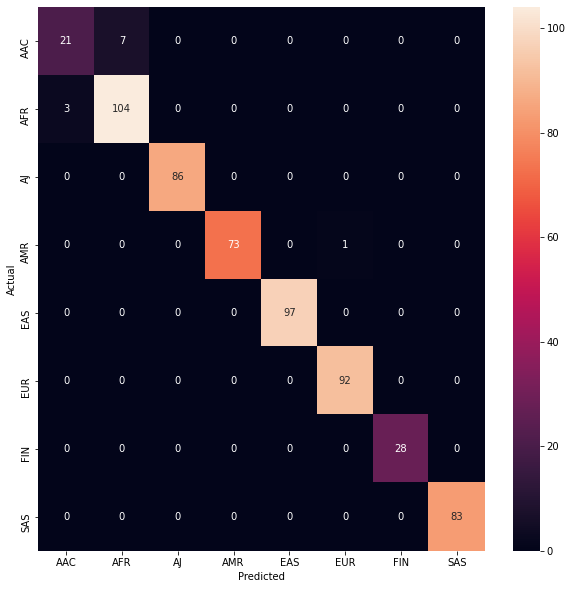

['/data/vitaled2/test_data/FIN/umap_linearsvc_ancestry_model.pkl']

In [15]:
print(pipe_grid.best_score_)
print(pipe_grid.best_params_)

pipe_clf = pipe_grid.best_estimator_
print(f"Accuracy on the test set with UMAP transformation: {pipe_clf.score(X_test, y_test)}")
pipe_clf_pred = pipe_clf.predict(X_test)

pipe_clf_c_matrix = metrics.confusion_matrix(y_test, pipe_clf_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pipe_clf_c_matrix, annot=True, fmt='d',
            xticklabels=le.inverse_transform([i for i in range(8)]), yticklabels=le.inverse_transform([i for i in range(8)]))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# dump best estimator to pkl
joblib.dump(pipe_clf, f'{out_path}/umap_linearsvc_ancestry_model.pkl')

# model = joblib.load(f'{out_path}/umap_linearsvc_ancestry_model.pkl')

In [ ]:
#encode labels
le = preprocessing.LabelEncoder()
y = le.fit_transform(labeled_pca.label)

# predict new samples!
ancestry_pred = pipe_clf.predict(X_new)


In [21]:
X_new_ids.loc[:,'label'] = le.inverse_transform(ancestry_pred)

/home/vitaled2/.local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/vitaled2/.local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


a: 0.5 b: 0.5


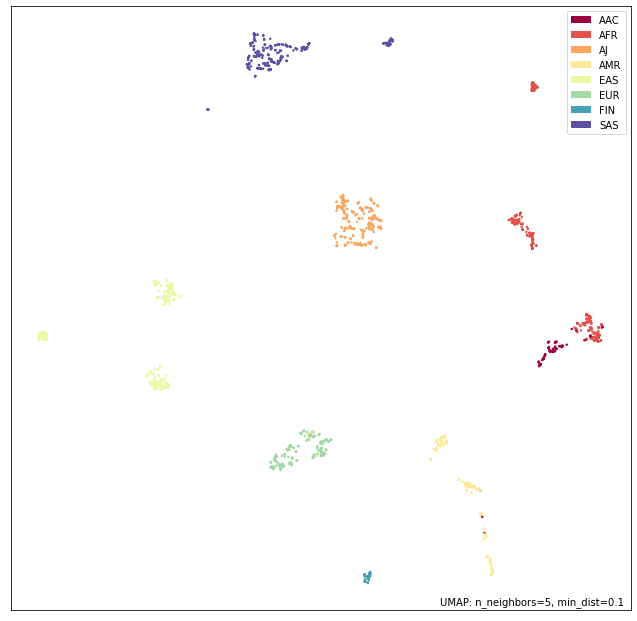

a: 0.5 b: 0.75


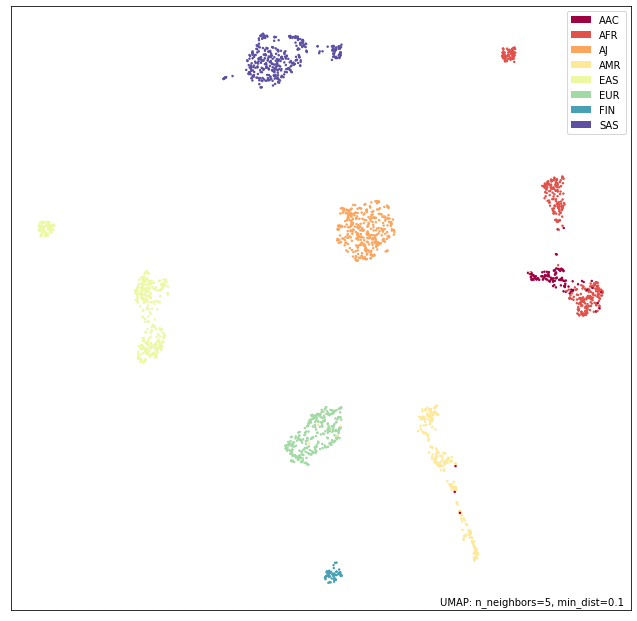

a: 0.5 b: 1.0


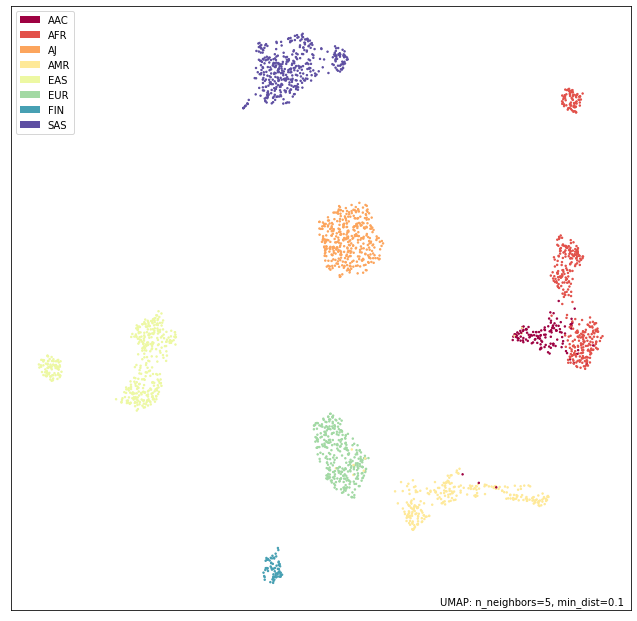

a: 0.5 b: 1.25


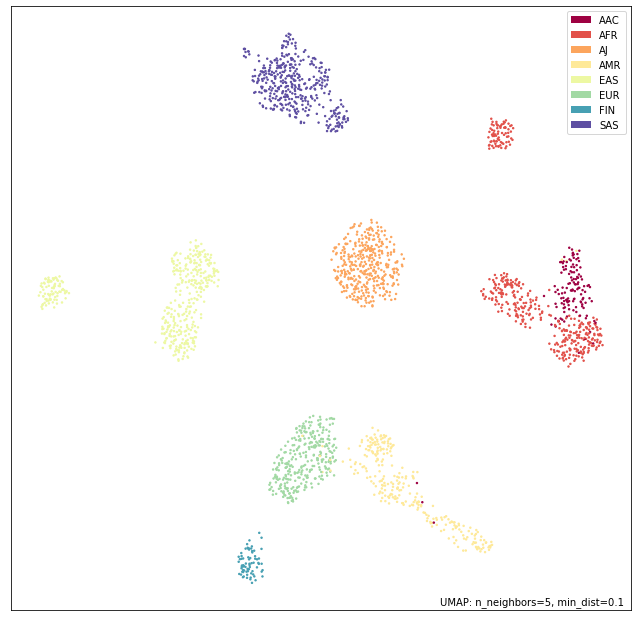

a: 0.5 b: 1.5


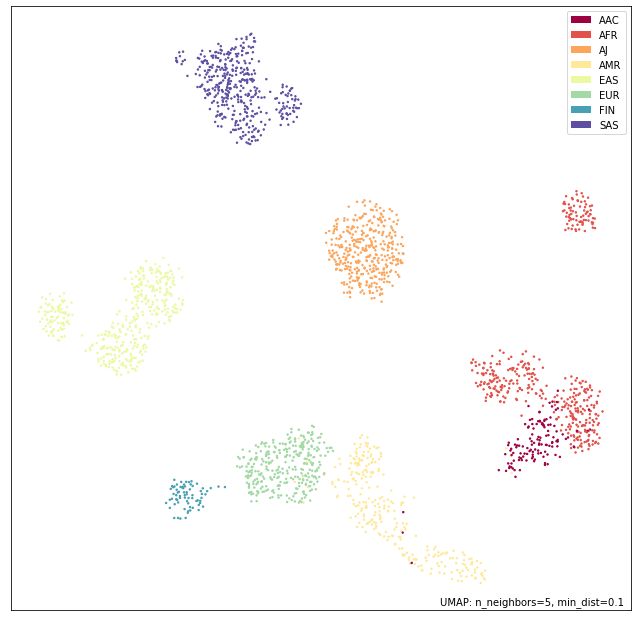

a: 0.75 b: 0.5


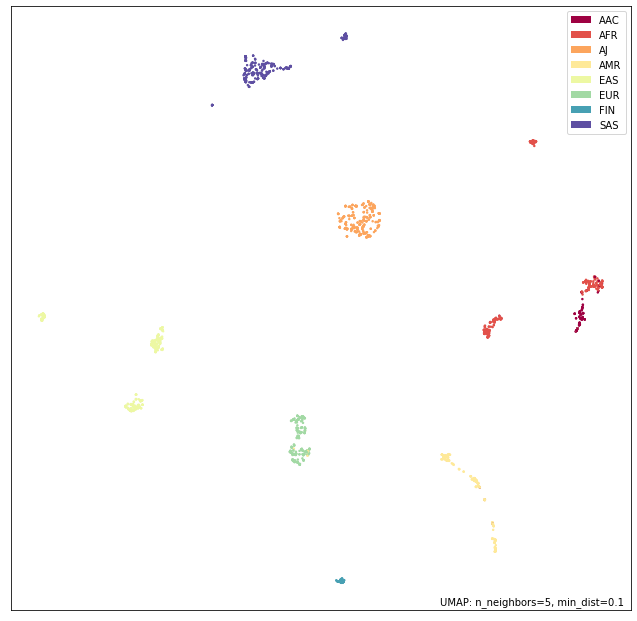

a: 0.75 b: 0.75


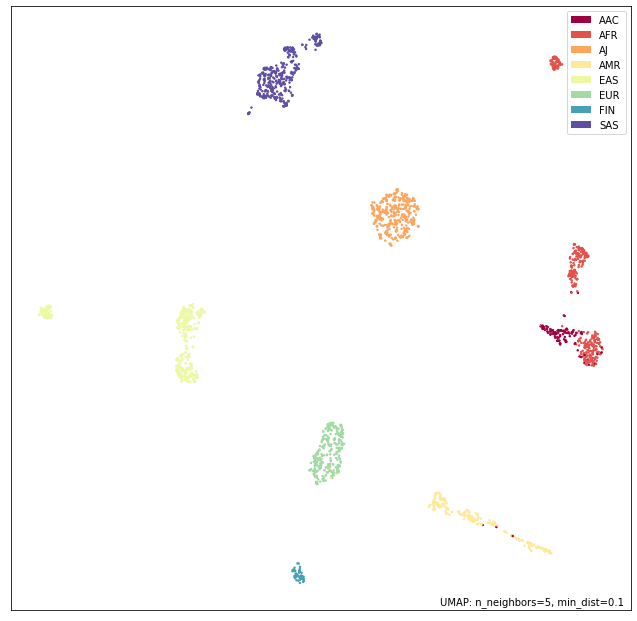

a: 0.75 b: 1.0


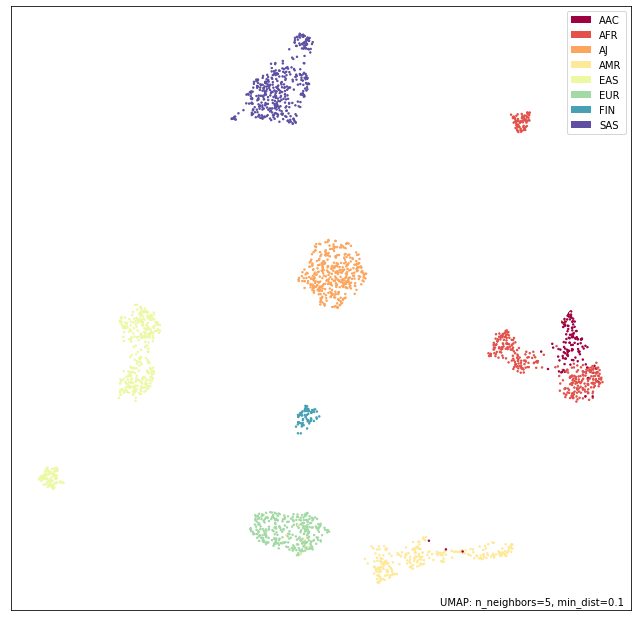

a: 0.75 b: 1.25


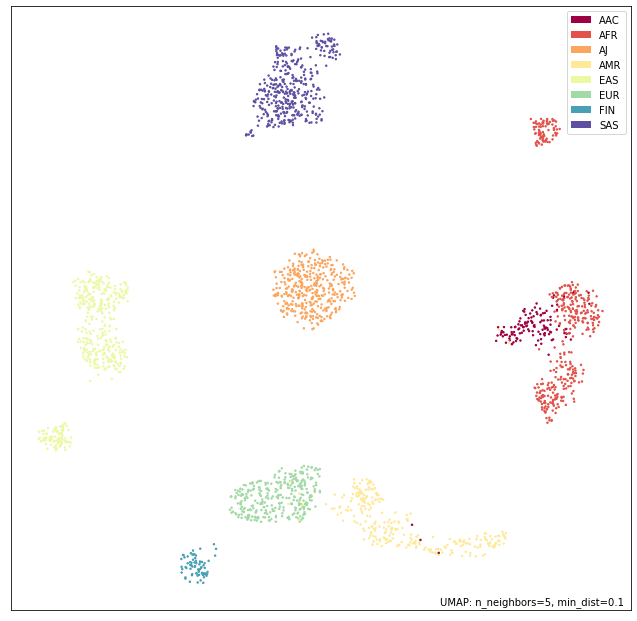

a: 0.75 b: 1.5


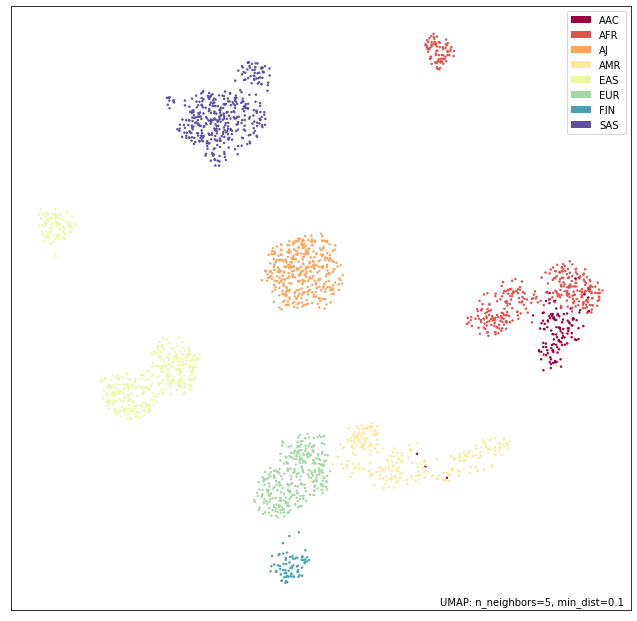

a: 1.0 b: 0.5


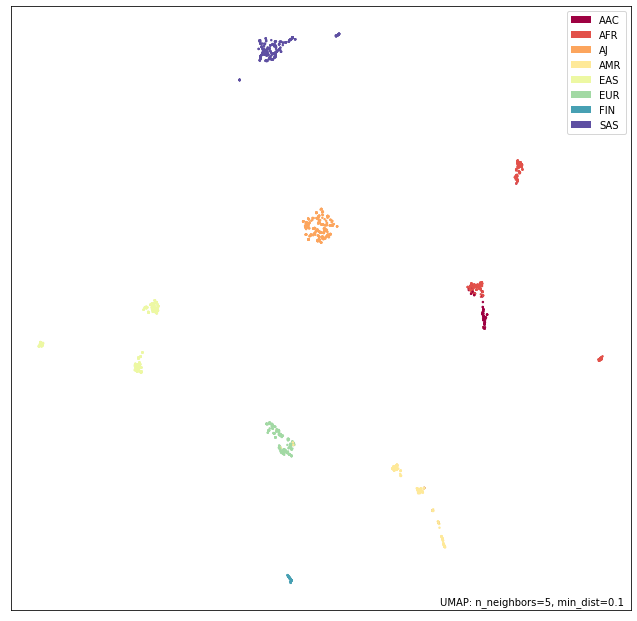

a: 1.0 b: 0.75


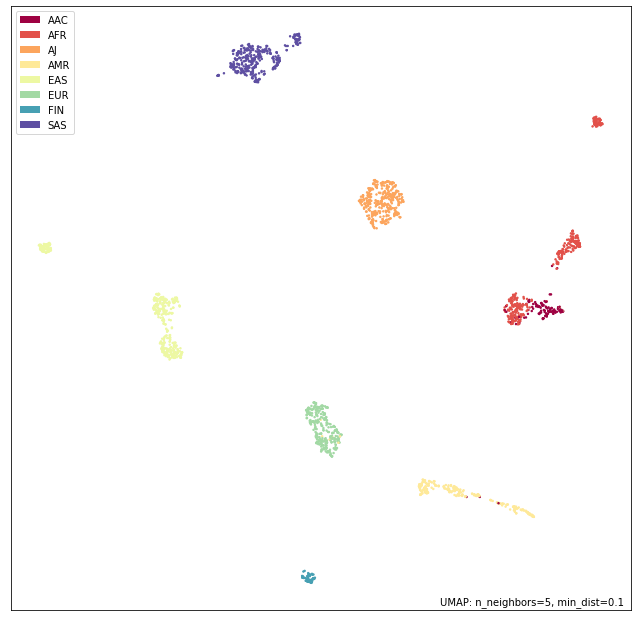

a: 1.0 b: 1.0


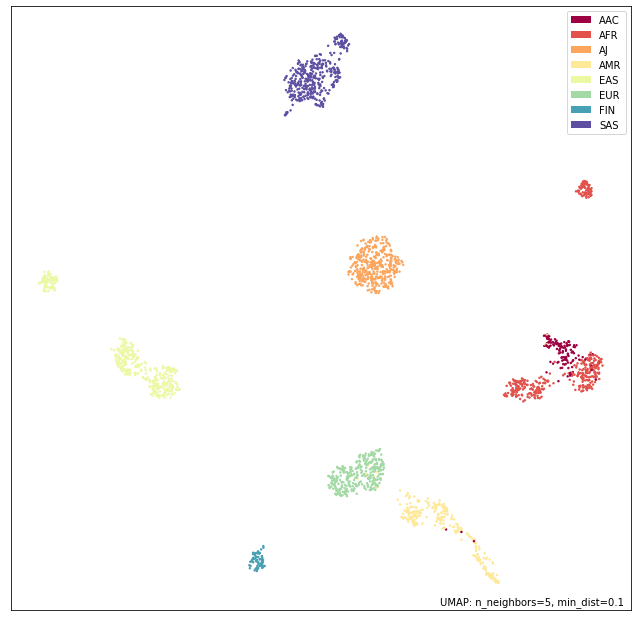

a: 1.0 b: 1.25


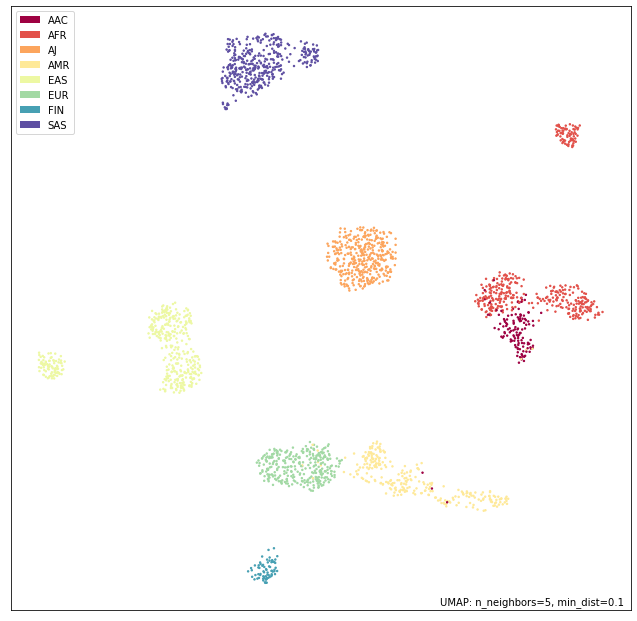

a: 1.0 b: 1.5


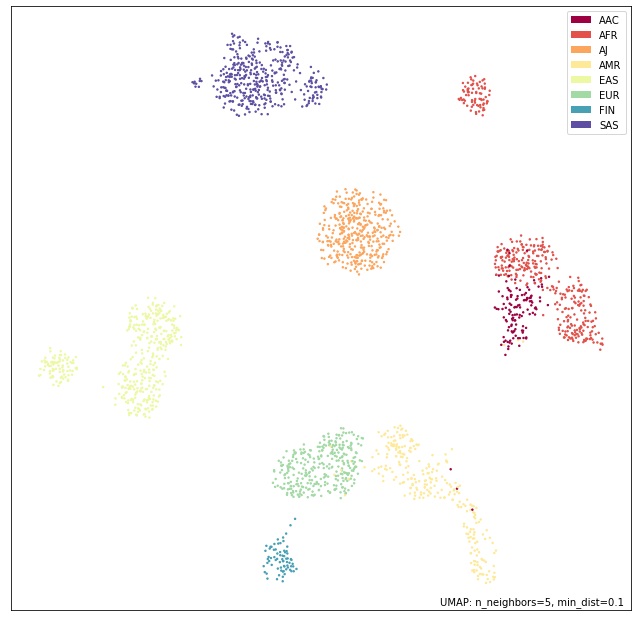

a: 1.25 b: 0.5


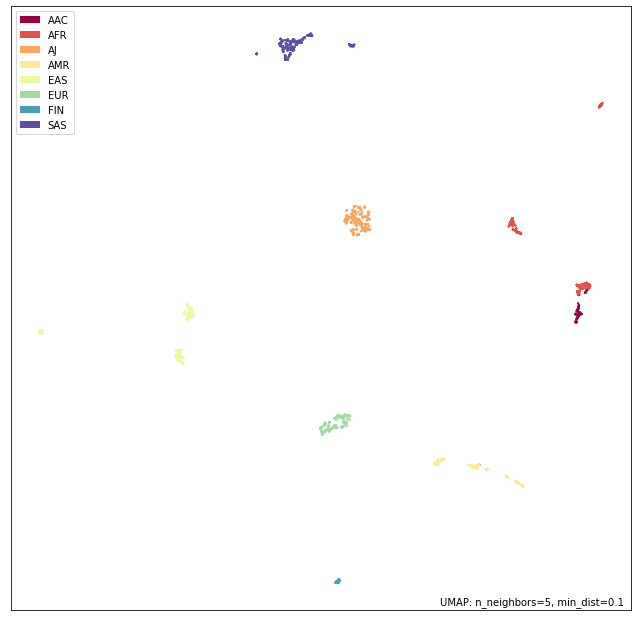

a: 1.25 b: 0.75


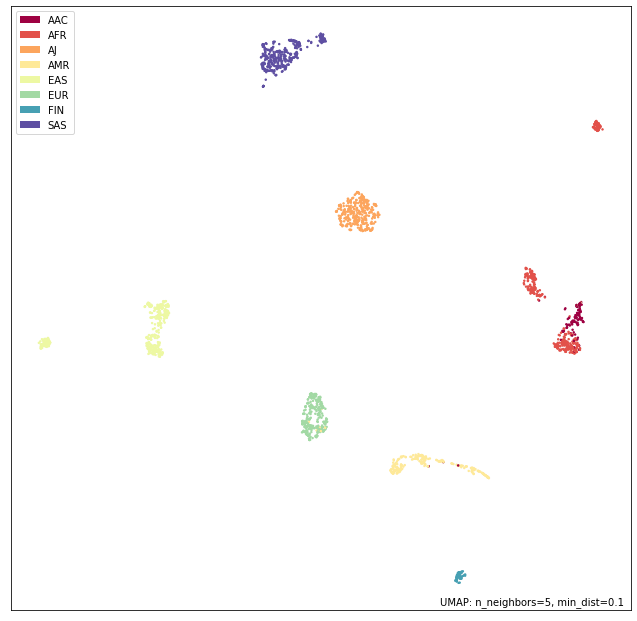

a: 1.25 b: 1.0


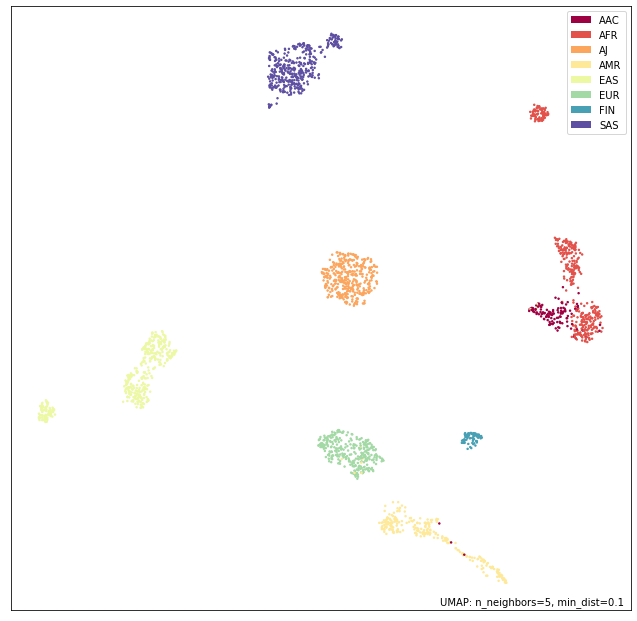

a: 1.25 b: 1.25


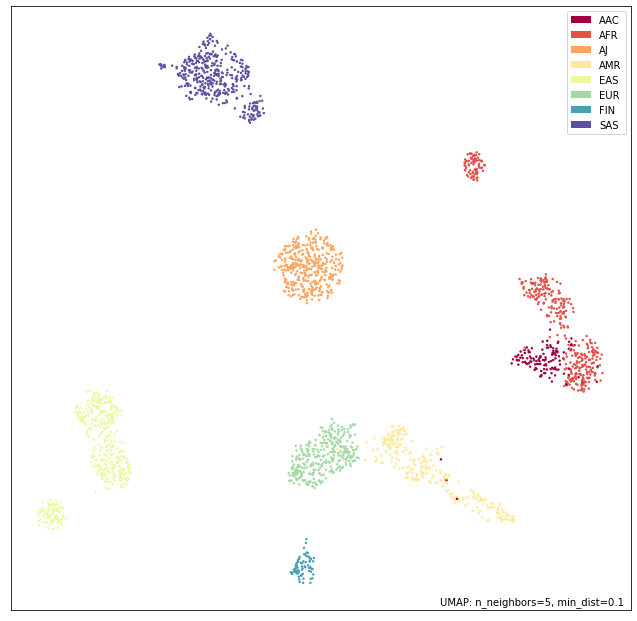

a: 1.25 b: 1.5


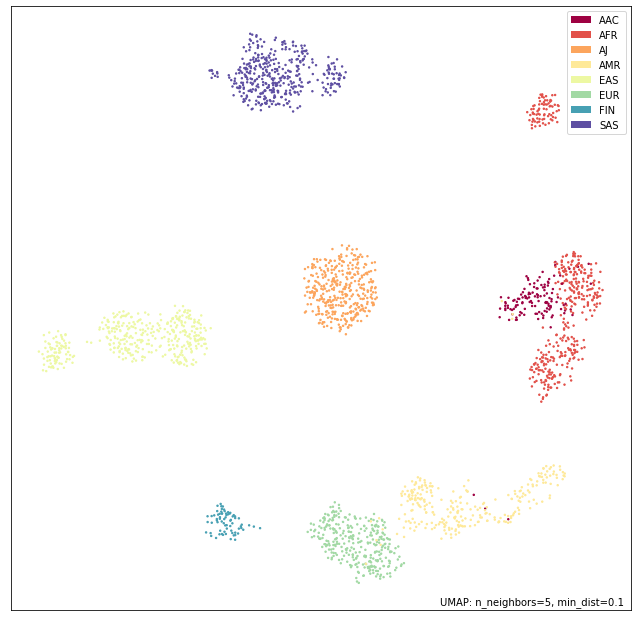

a: 1.5 b: 0.5


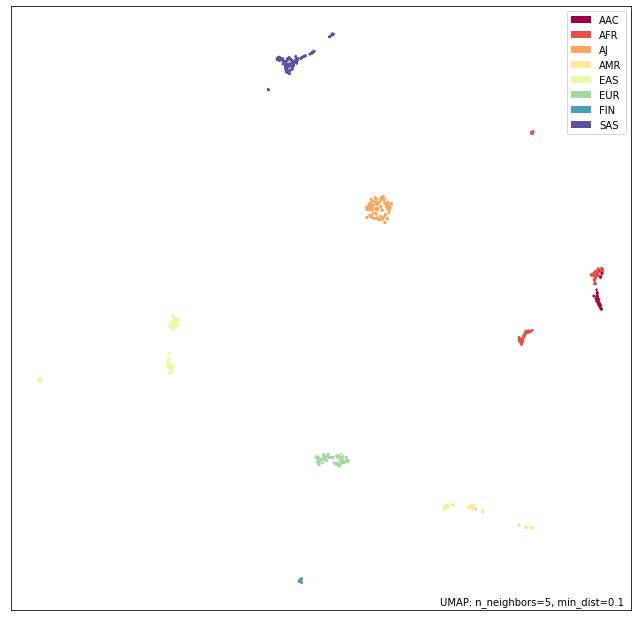

a: 1.5 b: 0.75


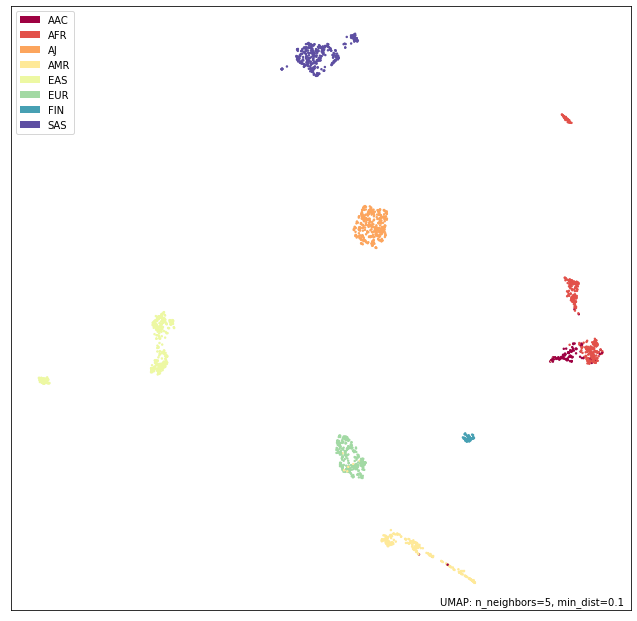

a: 1.5 b: 1.0


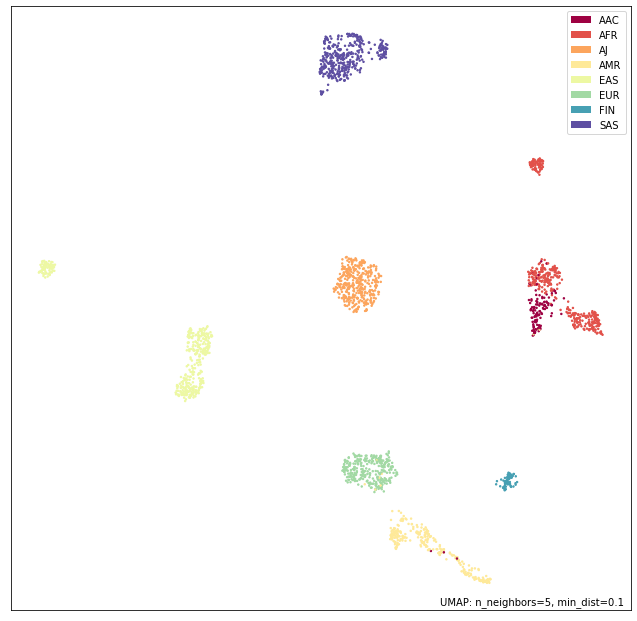

a: 1.5 b: 1.25


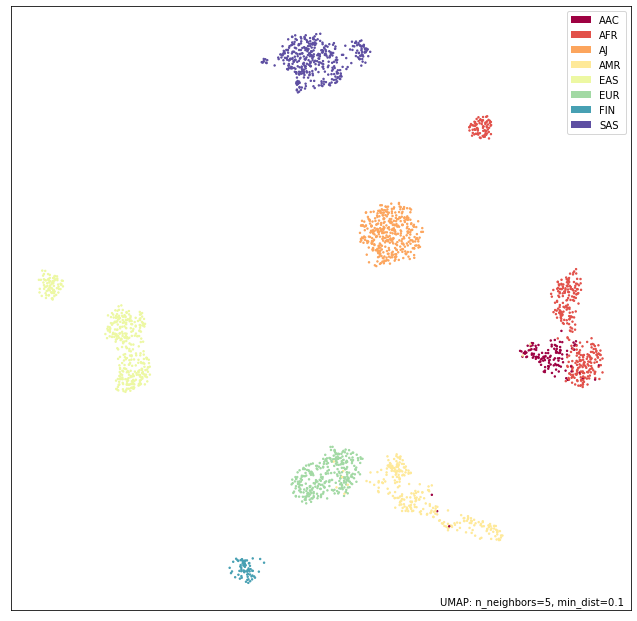

a: 1.5 b: 1.5


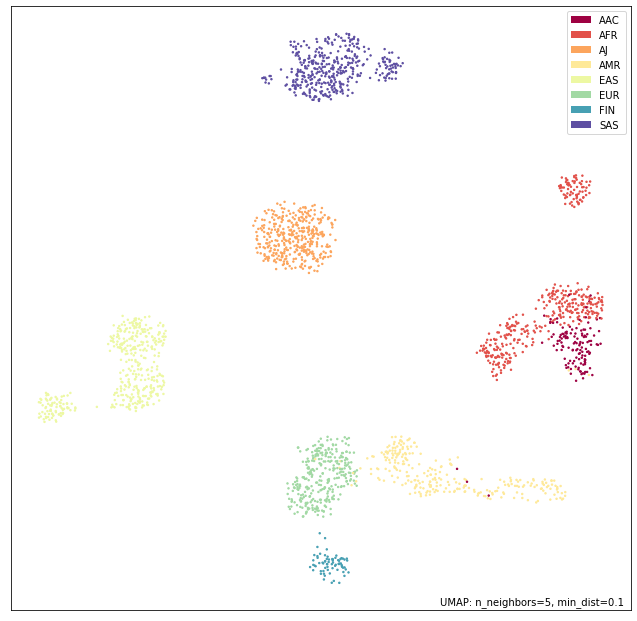

In [24]:
# test different hypterparameters for UMAP
min_dists = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
_a=[0.5, 0.75, 1.0, 1.25, 1.5]
_b=[0.5, 0.75, 1.0, 1.25, 1.5]

# mappers = []
# for min_dist in min_dists:
#     print(min_dist)
#     mapper = UMAP(random_state=123, n_components=2, n_neighbors=5, min_dist=min_dist).fit(X_train)
#     mappers.append(mapper)
#     umap_plot.points(mapper, labels=le.inverse_transform(y_train))
#     plt.show()

for a in _a:
    for b in _b:
        print('a:', a, 'b:', b)
        mapper = UMAP(random_state=123, n_components=2, n_neighbors=5, a=a, b=b).fit(X_train)
        mappers.append(mapper)
        umap_plot.points(mapper, labels=le.inverse_transform(y_train))
        plt.show()

# 'umap__n_components': 15, 'umap__n_neighbors': 5


array([2, 1, 1, ..., 1, 4, 3])

In [22]:
X_new_ids.label.value_counts()

FIN    735
EUR    144
Name: label, dtype: int64

In [30]:
pipe_clf.named_steps.umap

UMAP(n_components=15, n_neighbors=20, random_state=123)

In [12]:
# now merge ref and geno and run faststructure
merged_ref_geno = f'{geno_het}_merged_ref'

merge_genos(geno_common_snps, ref_panel_common_snps, merged_ref_geno)

Executing: plink --bfile /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_common_snps --allow-no-sex --bmerge /data/vitaled2/test_data/FIN/ref_panel_common_snps --out /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_merged_ref --make-bed
Executing: plink --bfile /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_common_snps --allow-no-sex --flip /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_merged_ref-merge.missnp --make-bed --out /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_common_snps_flip
Executing: plink --bfile /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_common_snps_flip --allow-no-sex --bmerge /data/vitaled2/test_data/FIN/ref_panel_common_snps --out /data/vitaled2/test_data/FIN/PD.FIN_call_rate_sex_het_merged_ref_flip --make-bed
